In [1]:
""" 
NOTEBOOK :  ntbk_figures_clim_data.ipynb 

This notebook produces the figures for the paper: 

 Boosting ensemble size of climate fields using generative machine learning; a proof of concept
  by P. Gooya, R. Sospedra-Alfonso, and J. Exenberger submitted to XXXX

STATUS  : Complete - needs checking results in full detail
COMMENTS: (1) The boosted ensemble appears to capture the known assymetries in 
              anomalies for el nino vs la nina, seen in the population and training sample
          (2) The variance of population extremes seems off   
"""""

' \nNOTEBOOK :  ntbk_figures_clim_data.ipynb \n\nThis notebook produces the figures for the paper: \n\n Boosting ensemble size of climate fields using generative machine learning; a proof of concept\n  by P. Gooya, R. Sospedra-Alfonso, and J. Exenberger submitted to XXXX\n\nSTATUS  : Complete - needs checking results in full detail\nCOMMENTS: (1) The boosted ensemble appears to capture the known assymetries in \n              anomalies for el nino vs la nina, seen in the population and training sample\n          (2) The variance of population extremes seems off   \n'

In [1]:
import os
import yaml 
import gc
import matplotlib.pyplot as plt


filename = f'{os.getcwd()[:-10]}/config_pr.yaml'
with open(filename) as f:
    dict_yaml = yaml.load(f, Loader=yaml.loader.SafeLoader)

var            = dict_yaml['variable'][0]
dir_source     = dict_yaml['dir_source']
dir_frnt_out   = dict_yaml['dir_frnt_out']
dict_hist   = dict_yaml['data_hist_info']
list_data  = dict_yaml['list_data_raw'] + dict_yaml['list_data_hist']
dict_seasons = dict_yaml['dict_seasons']

In [2]:
import warnings
warnings.filterwarnings('ignore')

import sys
sys.path.insert(1, f'{dir_source}')

from modules.data_load     import load_hist_data
from modules.info_plt      import plt_module
from modules.plot_package  import plot_ts, plot_hist, plot_qq, plot_map
from modules.util_analysis import enso_extremes, corr_patt
from modules.util_glbavg   import *

## Set Up ##

In [3]:
dir_out  = f'{dir_frnt_out}' 

In [4]:
dict_event_plt = plt_module().dict_event_plt
dict_hist_plt   = plt_module().dict_hist_plt

In [5]:
quantiles = np.linspace(start=0,stop=1,num=int(100))[1:-1]
quantiles_enso = ['None', '0.75', '0.85']
quantiles_extremes = [0.01, 0.99]
events    = ['nino', 'nina']

## Load Data ##

In [6]:
test_years = np.arange(2010,2020)

In [7]:
dict_data = load_hist_data([key for key in list_data if key != 'train_sample'],
                          dict_hist, var = var)

population
====
hist_VAE2
====
hist_benchmark
====
population_extention
====


In [8]:
equal_members = False

for key, ds in dict_data.items():
    dict_data[key] = ds.sel(year = test_years).clip(0, None)
    if all([max(test_years) >= 2015, 'population' in key]):
        dict_data[key] = dict_data[key].sel(realization = [f'r{i}i1p2f1' for i in range(1,26)])
    if equal_members:
        try:
            dict_data[key] = dict_data[key].isel(realization = np.arange(len(dict_data['population'].realization)))
        except:
            pass

In [9]:
bias_correct = True

if bias_correct:
    for key, ds in dict_data.items():
        if all([key not in ['population', 'train_sample'], 'train_sample' in dict_data.keys()]):
            dict_data[key] = dict_data[key] - dict_data[key].mean('realization') + dict_data['train_sample'].mean('realization')

In [10]:
idisplay = True
if idisplay:
    for idata in list_data:
        display(dict_data[idata])

<xarray.Dataset>
Dimensions:      (year: 10, realization: 25, time: 12, lat: 64, lon: 128)
Coordinates:
  * time         (time) int64 1 2 3 4 5 6 7 8 9 10 11 12
  * lat          (lat) float64 -87.86 -85.1 -82.31 -79.53 ... 82.31 85.1 87.86
  * lon          (lon) float64 0.0 2.812 5.625 8.438 ... 348.8 351.6 354.4 357.2
  * realization  (realization) object 'r1i1p2f1' 'r2i1p2f1' ... 'r25i1p2f1'
  * year         (year) int64 2010 2011 2012 2013 2014 2015 2016 2017 2018 2019
Data variables:
    pr           (year, realization, time, lat, lon) float32 dask.array<chunksize=(5, 25, 12, 64, 128), meta=np.ndarray>

<xarray.Dataset>
Dimensions:      (year: 10, realization: 10, time: 12, lat: 64, lon: 128)
Coordinates:
  * time         (time) int64 1 2 3 4 5 6 7 8 9 10 11 12
  * lat          (lat) float64 -87.86 -85.1 -82.31 -79.53 ... 82.31 85.1 87.86
  * lon          (lon) float64 0.0 2.812 5.625 8.438 ... 348.8 351.6 354.4 357.2
  * realization  (realization) object 'r10i1p2f1' 'r11i1p2f1' ... 'r19i1p2f1'
  * year         (year) int64 2010 2011 2012 2013 2014 2015 2016 2017 2018 2019
Data variables:
    pr           (year, realization, time, lat, lon) float32 dask.array<chunksize=(5, 10, 12, 64, 128), meta=np.ndarray>

<xarray.Dataset>
Dimensions:      (lat: 64, lon: 128, time: 12, realization: 500, year: 10)
Coordinates:
  * lat          (lat) float64 -87.86 -85.1 -82.31 -79.53 ... 82.31 85.1 87.86
  * lon          (lon) float64 0.0 2.812 5.625 8.438 ... 348.8 351.6 354.4 357.2
  * time         (time) int64 1 2 3 4 5 6 7 8 9 10 11 12
  * realization  (realization) int64 1 2 3 4 5 6 7 ... 495 496 497 498 499 500
  * year         (year) int64 2010 2011 2012 2013 2014 2015 2016 2017 2018 2019
Data variables:
    pr           (year, time, realization, lat, lon) float32 dask.array<chunksize=(1, 12, 500, 64, 128), meta=np.ndarray>

<xarray.Dataset>
Dimensions:      (lat: 64, lon: 128, time: 12, realization: 500, year: 10)
Coordinates:
  * lat          (lat) float64 -87.86 -85.1 -82.31 -79.53 ... 82.31 85.1 87.86
  * lon          (lon) float64 0.0 2.812 5.625 8.438 ... 348.8 351.6 354.4 357.2
  * time         (time) int64 1 2 3 4 5 6 7 8 9 10 11 12
  * realization  (realization) int64 1 2 3 4 5 6 7 ... 495 496 497 498 499 500
  * year         (year) int64 2010 2011 2012 2013 2014 2015 2016 2017 2018 2019
Data variables:
    pr           (year, time, realization, lat, lon) float32 dask.array<chunksize=(1, 12, 500, 64, 128), meta=np.ndarray>

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


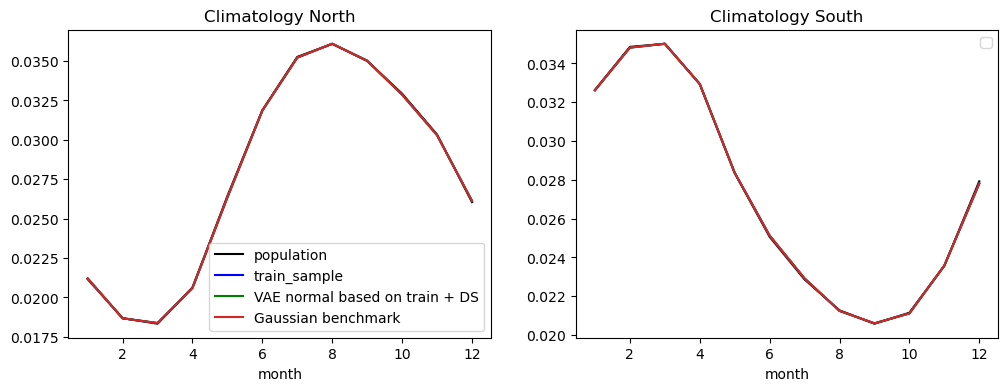

In [11]:
idisplay = True

if idisplay:

    plt.figure(figsize=(12,4))
    for i, hemisphere in enumerate(['North', 'South']):
        plt.subplot(1,2,i+1)
        for idata in list_data:
            if idata == 'obs':
                coords_for_clim = ['year', 'lat', 'lon']
            else:
                coords_for_clim = ['year','realization', 'lat', 'lon']
            if hemisphere == 'North':
                ds = dict_data[idata][var].where(dict_data[idata][var].lat >= 0 , drop = True).mean(coords_for_clim)
                plt.plot(np.arange(1,13), ds, color = dict_hist_plt[idata]['color'], label = dict_hist_plt[idata]['label'])
            else:
                ds = dict_data[idata][var].where(dict_data[idata][var].lat <= 0 , drop = True).mean(coords_for_clim)
                plt.plot(np.arange(1,13), ds, color = dict_hist_plt[idata]['color'])
        plt.title(f'Climatology {hemisphere}')
        plt.xlabel('month')
        plt.legend()

## Dictionaries ##

- Anomalies

In [12]:
dict_anom = {}
for idata in list_data:
    if idata == 'obs':
        coords_for_clim = ['year']
    else:
        coords_for_clim = ['year','realization']
    dict_anom[idata] = dict_data[idata] - dict_data[idata].mean(coords_for_clim)


    # if 'VAE' in idata:
    #     dict_anom[idata] = dict_anom[idata].where(dict_anom[idata] <= dict_anom['train_sample'].max() )  ### through out outliers
    #     dict_anom[idata] = dict_anom[idata].where(dict_anom[idata] >= dict_anom['train_sample'].min() ) ### through out outliers

- Quantiles

In [13]:
time_to_show = np.arange(1,13) 
dict_quantiles_flat = {}
for idata in list_data:
    print(idata)
    ds1 = dict_anom[idata][var].sel(time=time_to_show).values.flatten()
    ds1 = ds1[~np.isnan(ds1)]
    ds1_quantiles = np.quantile(ds1, quantiles, interpolation='nearest')
    dict_quantiles_flat[idata] = ds1_quantiles  # uses median .. 

population
train_sample
hist_VAE2
hist_benchmark


- Figure 3: QQ Plot

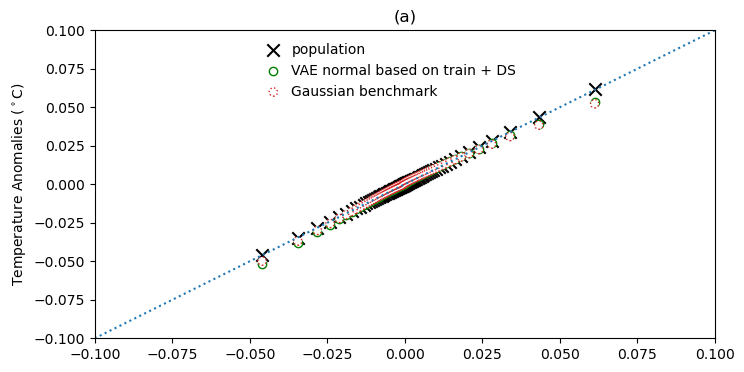

In [19]:
idata_ref = 'train_sample'
plot_qq([key for key in ['population','hist_VAE2','hist_benchmark'] if key != idata_ref],
        dict_quantiles_flat,
        idata_ref=idata_ref,
        dict_plt=dict_hist_plt,
        box=[[-0.1,-0.1],
             [0.1,0.1]],
            figsize=(8,4),
        bbox=(0.2,.5,.5,.5),
        title = '(a)',
        xlabel = '',
        dir_name= dir_frnt_out,
        file_name= 'Figure3_a',
        show=True,
        save=True)

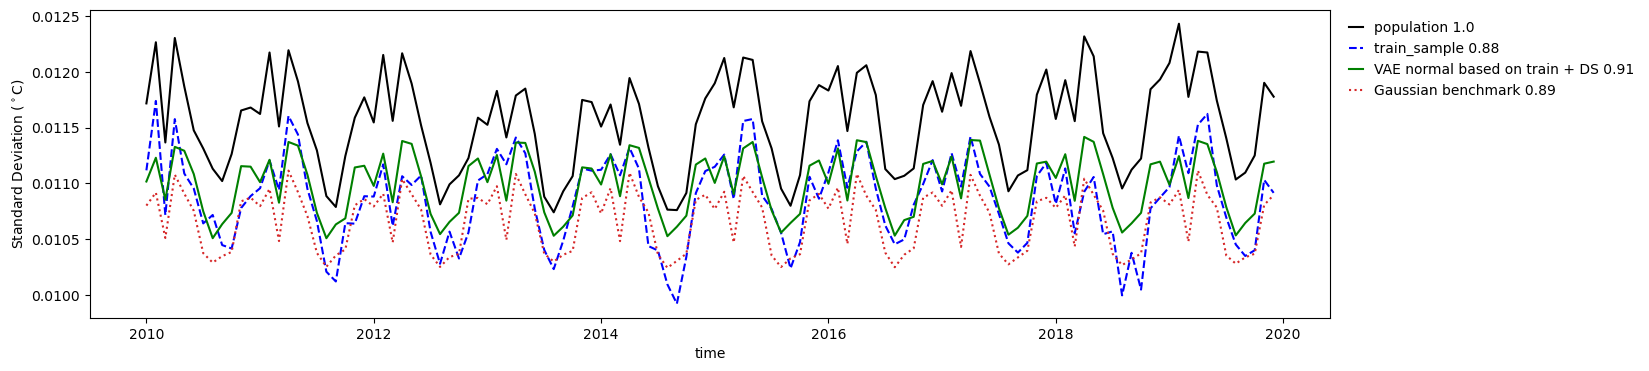

In [15]:



plt.figure(figsize = (16,4))

ref = dict_anom['population'][var].std('realization').stack(t = ('year','time')).mean(['lat','lon']).squeeze()
for idata, ds in dict_anom.items():
    dstp =  ds[var].std('realization').stack(t = ('year','time')).mean(['lat','lon']).squeeze()
    corr = xr.corr(dstp, ref).values

    plt.plot( np.arange(min(test_years),max(test_years) + 1,1/12) , 
                dstp, 
                label = dict_hist_plt[idata]['label'] + f' {str(np.round(corr,2))}', 
                color  = dict_hist_plt[idata]['color'], 
                linestyle = dict_hist_plt[idata]['linestyle'])
plt.ylabel('Standard Deviation ($^\circ$C)')
plt.xlabel('time')
plt.legend()
plt.legend(loc='best',
            bbox_to_anchor=[1.005,1.005],
            handlelength=1,
            ncol=1,
            frameon=False)  


- Nino 3.4

In [ ]:
# dict_enso = {}
# for idata in list_data:
#     dict_enso[idata] = dict_anom[idata].where((dict_anom[idata].lat >= -5) & (dict_anom[idata].lat<= 5),
#                                               drop=True)
#     dict_enso[idata] = dict_enso[idata].where((dict_enso[idata].lon >= 190) & (dict_enso[idata].lon<= 240),
#                                               drop=True).mean(['lat','lon'])    

- Nino 3.4 seasoal cycle

In [ ]:
# dict_enso_seas_cycle = {}
# for idata in list_data:
#     dimension = ['realization','year']
#     if idata in ['obs']:
#         dimension = 'year'
#     dict_enso_seas_cycle[idata] = dict_enso[idata].std(dimension)



- Nino 3.4 QQ plots

In [19]:
from tqdm import tqdm

In [ ]:
# mean_season = False

# seasons_to_show = ['DJF', 'JJA'] 
# # seasons_to_show = ['Full'] 
# dict_quantiles_flat_enso = {}

# for season in seasons_to_show:
#     print(season)
#     dict_quantiles_flat_enso[season] = {}
#     for idata in tqdm(list_data):
#         print(idata)
#         ds1 = dict_enso[idata][var].sel(time=dict_seasons[season])
#         if mean_season:
#             ds1 = ds1.mean('time')
#         ds1 = ds1.values.flatten()
#         ds1 = ds1[~np.isnan(ds1)]
#         ds1_quantiles = np.quantile(ds1, quantiles, interpolation='nearest')
#         dict_quantiles_flat_enso[season][idata] = ds1_quantiles  # uses median .. 

- Figure 3: Nino3.4 Seasonal Cycle

In [ ]:
# plot_ts(['population', 'train_sample', 'hist_VAE2',  'hist_benchmark'],
#         dict_enso_seas_cycle,
#         dict_plot=dict_hist_plt,
#         bbox= None, #(-0,-0.1,.5,.5),
#         figsize=(8,4),
#         title=f'(b)',
#         xlabel=f'Month',
#         ylabel=f'Standard Deviation ($^\circ$C)',
#         dir_name= dir_frnt_out,
#         file_name= 'Figure3_c',
#         show=True,
#         save=False)

- ENSO Histograms

In [ ]:
# for season in seasons_to_show:
#   plot_hist(['population', 'train_sample','hist_VAE2',  'hist_benchmark'],
#             dict_enso,
#             dict_hist_plt,
#             season=season,
#             seasons_dict = dict_seasons,
#             mean_season=mean_season,
#             nbins=20,
#             xlabel='Anomalies ($^\circ$C)',
#             ylabel='Log Density',
#             title='(d) ',
#                 fig_dir= dir_frnt_out,
#             fig_name= 'Figure3_d',
#             legend_bool = (True, True, True, True),
#             bbox=(0.9,.5,.5,.5),
#               xmin=-4,
#               xmax=4,
#               skewness=True,
#             show = True,
#             save = False)

- QQ plots

In [ ]:
# idata_ref = 'train_sample'
# seasons_to_show = ['DJF', 'JJA']
# # seasons_to_show = ['Full']

# for season in seasons_to_show:
#     plot_qq([key for key in ['population','hist_VAE2', 'hist_benchmark'] if key != idata_ref],
#             dict_quantiles_flat_enso[season],
#             idata_ref=idata_ref,
#             dict_plt=dict_hist_plt,
#             box=[[-2.5,-2.5],
#                 [2.5,2.5]],
#                 figsize=(8,4),
#             bbox=(0.05,.5,.5,.5),
#             title = '(a)',
#             xlabel = '',
#             dir_name= dir_frnt_out,
#             file_name= 'Figure3_a',
#             text_dict = {'text' : season, 'x' : 0.9, 'y' : 0.05} if season != 'Full' else None,
#             show=True,
#             save=True)

- time series

In [ ]:



# plt.figure(figsize = (16,4))

# ref = dict_enso['population'][var].std('realization').stack(t = ('year','time')).squeeze()
# for idata, ds in dict_enso.items():
#     dstp =  ds[var].std('realization').stack(t = ('year','time')).squeeze()
#     corr = xr.corr(dstp, ref).values

#     plt.plot( np.arange(min(test_years),max(test_years) + 1,1/12) , 
#                 dstp, 
#                 label = dict_hist_plt[idata]['label'] + f' {str(np.round(corr,2))}', 
#                 color  = dict_hist_plt[idata]['color'], 
#                 linestyle = dict_hist_plt[idata]['linestyle'])
# plt.ylabel('Standard Deviation ($^\circ$C)')
# plt.xlabel('time')
# plt.legend()
# plt.legend(loc='best',
#             bbox_to_anchor=[1.005,1.005],
#             handlelength=1,
#             ncol=1,
#             frameon=False)  


- Figure 3: Regional Analysis - Vancouver London 

In [20]:
dict_regional_anom = {}

for region in ['Canada', 'Vancouver', 'London', 'Hong Kong']:
    dict_regional_anom[region] = {}
for idata in list_data:

    d = dict_anom[idata].where((dict_anom[idata].lat >= 48) & (dict_anom[idata].lat<= 70),
                                              drop=True)
    dict_regional_anom['Canada'][idata] = d.where((d.lon >= 219) & (d.lon<= 304),
                                              drop=True).mean(['lat','lon'])     
    dict_regional_anom['Vancouver'][idata] = dict_anom[idata].sel(lat = 46, lon = 237,  method='nearest')
    dict_regional_anom['London'][idata] = dict_anom[idata].sel(lat = 51.5, lon = 0,  method='nearest')
    dict_regional_anom['Hong Kong'][idata] = dict_anom[idata].sel(lat = 22.3, lon = 114,  method='nearest')

In [21]:
dict_regional_anom_seas_cycle = {}

for key, ds in dict_regional_anom.items():
    dict_regional_anom_seas_cycle[key] = {}
    for idata in list_data:
        dimension = ['realization','year']
        if idata in ['obs']:
            dimension = 'year'
        dict_regional_anom_seas_cycle[key][idata] = dict_regional_anom[key][idata].std(dimension)

In [22]:
from tqdm import tqdm

In [24]:
mean_season  =False
seasons_to_show = ['DJF', 'JJA'] 
# seasons_to_show = ['Full'] 
dict_quantiles_flat_regional = {}


for season in seasons_to_show:
    print(season)
    dict_quantiles_flat_regional[season] = {}
    for key, ds in dict_regional_anom.items():
        dict_quantiles_flat_regional[season][key] = {}
        for idata in tqdm(list_data):
                print(idata)
                ds1 = dict_regional_anom[key][idata][var].sel(time=dict_seasons[season])
                if mean_season:
                    ds1 = ds1.mean('time')
                ds1 = ds1.values.flatten()
                ds1 = ds1[~np.isnan(ds1)]
                ds1_quantiles = np.quantile(ds1, quantiles, interpolation='nearest')
                dict_quantiles_flat_regional[season][key][idata] = ds1_quantiles  # uses median .. 



DJF


  0%|          | 0/4 [00:00<?, ?it/s]

population


 25%|██▌       | 1/4 [00:10<00:30, 10.32s/it]

train_sample


 50%|█████     | 2/4 [00:19<00:19,  9.88s/it]

hist_VAE2


 75%|███████▌  | 3/4 [00:33<00:11, 11.46s/it]

hist_benchmark


  0%|          | 0/4 [00:00<?, ?it/s]

population


 25%|██▌       | 1/4 [00:09<00:28,  9.50s/it]

train_sample


 50%|█████     | 2/4 [00:19<00:19,  9.59s/it]

hist_VAE2


 75%|███████▌  | 3/4 [00:30<00:10, 10.44s/it]

hist_benchmark


  0%|          | 0/4 [00:00<?, ?it/s]

population


 25%|██▌       | 1/4 [00:09<00:28,  9.50s/it]

train_sample


 50%|█████     | 2/4 [00:19<00:19,  9.53s/it]

hist_VAE2


 75%|███████▌  | 3/4 [00:31<00:11, 11.08s/it]

hist_benchmark


  0%|          | 0/4 [00:00<?, ?it/s]

population


 25%|██▌       | 1/4 [00:09<00:28,  9.49s/it]

train_sample


 50%|█████     | 2/4 [00:19<00:19,  9.55s/it]

hist_VAE2


 75%|███████▌  | 3/4 [00:30<00:10, 10.43s/it]

hist_benchmark


100%|██████████| 4/4 [00:42<00:00, 10.70s/it]


JJA


  0%|          | 0/4 [00:00<?, ?it/s]

population


 25%|██▌       | 1/4 [00:09<00:28,  9.64s/it]

train_sample


 50%|█████     | 2/4 [00:19<00:19,  9.65s/it]

hist_VAE2


 75%|███████▌  | 3/4 [00:32<00:11, 11.05s/it]

hist_benchmark


  0%|          | 0/4 [00:00<?, ?it/s]

population


 25%|██▌       | 1/4 [00:09<00:28,  9.55s/it]

train_sample


 50%|█████     | 2/4 [00:19<00:19,  9.59s/it]

hist_VAE2


 75%|███████▌  | 3/4 [00:30<00:10, 10.31s/it]

hist_benchmark


  0%|          | 0/4 [00:00<?, ?it/s]

population


 25%|██▌       | 1/4 [00:09<00:28,  9.58s/it]

train_sample


 50%|█████     | 2/4 [00:19<00:19,  9.68s/it]

hist_VAE2


 75%|███████▌  | 3/4 [00:32<00:11, 11.26s/it]

hist_benchmark


  0%|          | 0/4 [00:00<?, ?it/s]

population


 25%|██▌       | 1/4 [00:09<00:28,  9.56s/it]

train_sample


 50%|█████     | 2/4 [00:19<00:19,  9.57s/it]

hist_VAE2


 75%|███████▌  | 3/4 [00:30<00:10, 10.38s/it]

hist_benchmark


100%|██████████| 4/4 [00:42<00:00, 10.61s/it]


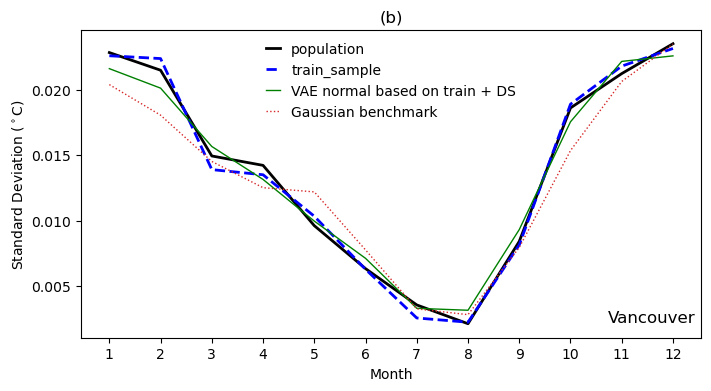

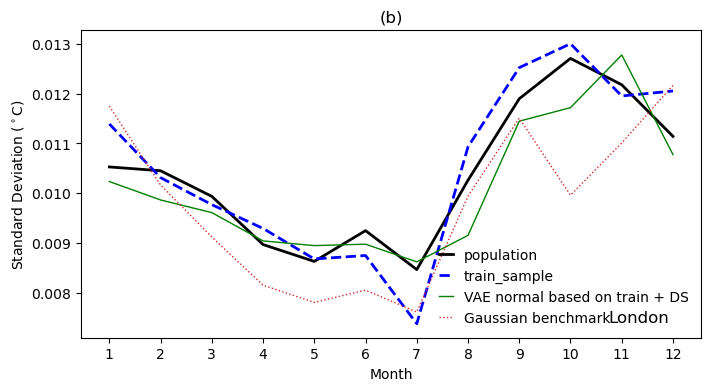

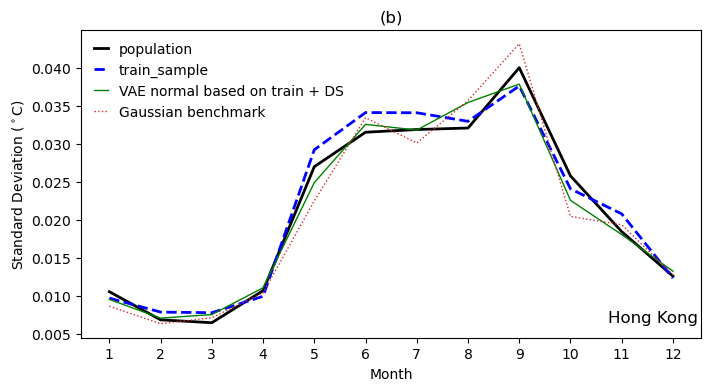

In [26]:

for region in ['Vancouver', 'London', 'Hong Kong']:
        plot_ts(['population', 'train_sample', 'hist_VAE2', 'hist_benchmark'],
                dict_regional_anom_seas_cycle[region],
                dict_plot=dict_hist_plt,
                var=var,
                bbox= None, #(-0,-0.1,.5,.5),
                figsize=(8,4),
                title=f'(b)',
                xlabel=f'Month',
                ylabel=f'Standard Deviation ($^\circ$C)',
                text_dict = {'text' : region, 'x': 0.85, 'y':0.05 },
                dir_name= dir_frnt_out, 
                file_name= 'Figure3_c',
                show=True,
                save=False)

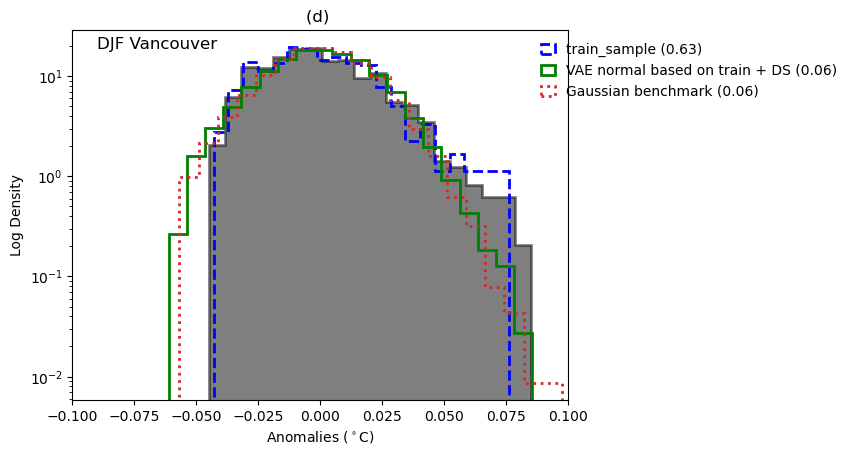

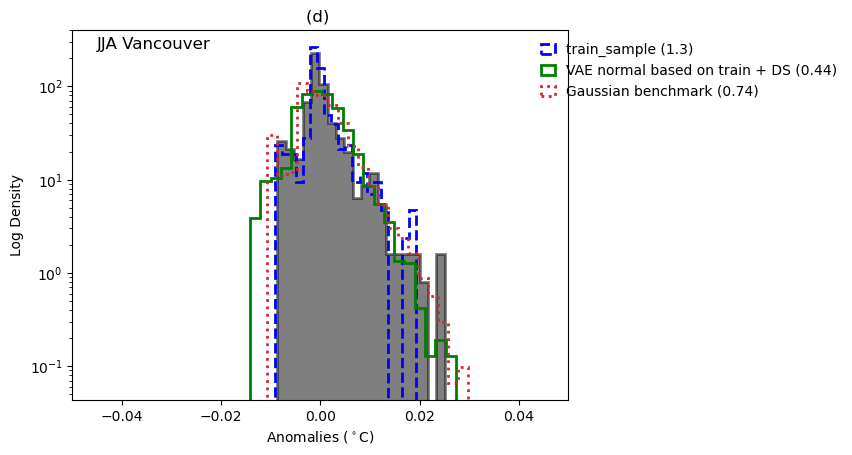

In [29]:
seasons_to_show = ['DJF', 'JJA']
# seasons_to_show = ['Full'] 

region = 'Vancouver'
for season in seasons_to_show:
  if season == 'DJF':
        xmin=-0.1
        xmax=0.1
  else:
        xmin=-0.05
        xmax=0.05

  
  plot_hist(['population', 'train_sample','hist_VAE2', 'hist_benchmark'],
            dict_regional_anom[region],
            dict_hist_plt,
            var=var,
            season=season,
            mean_season=mean_season,
            text_dict = {'text' : region , 'x' : 0.05, 'y' : 0.95},
            nbins=20,
            xlabel='Anomalies ($^\circ$C)',
            ylabel='Log Density',
            title='(d) ',
                fig_dir= dir_frnt_out,
            fig_name= 'Figure3_d',
            legend_bool = (False, True, True, True),
            bbox=(0.92,.5,.5,.5),
              xmin=xmin,
              xmax=xmax,
              skewness = True,
            show = True,
            save = False)

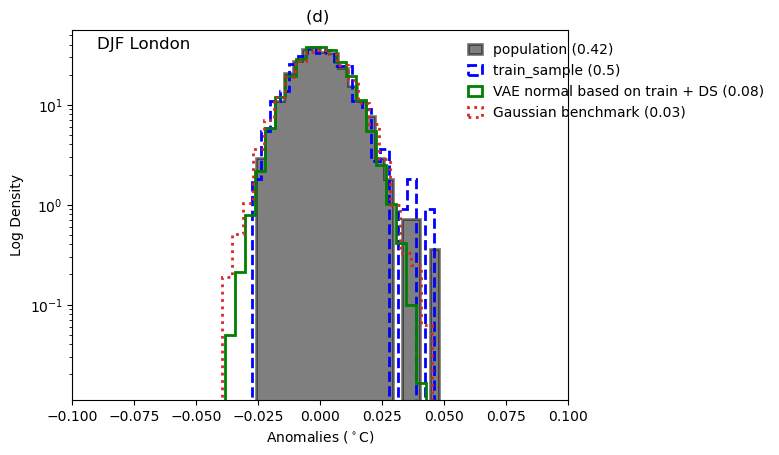

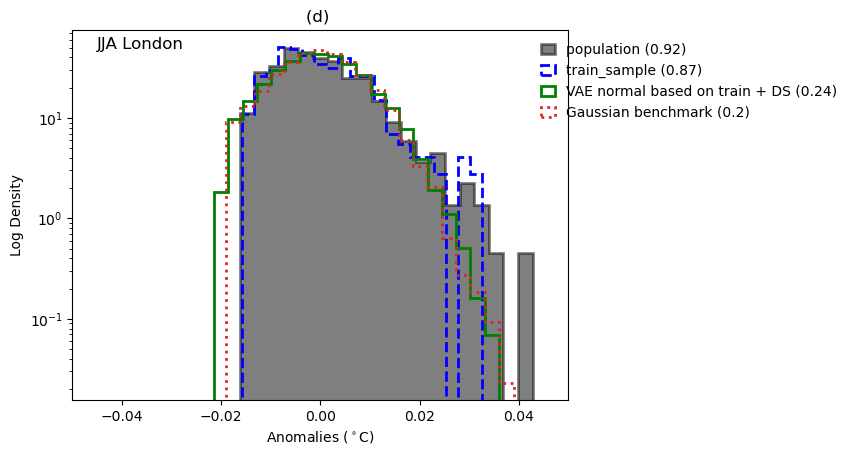

In [30]:
seasons_to_show = ['DJF', 'JJA']
# seasons_to_show = ['Full'] 

region = 'London'
for season in seasons_to_show:
  if season == 'DJF':
        xmin=-0.1
        xmax=0.1
  else:
        xmin=-0.05
        xmax=0.05  

  
  plot_hist(['population', 'train_sample','hist_VAE2', 'hist_benchmark'],
            dict_regional_anom[region],
            dict_hist_plt,
            season=season,
             var=var,
            mean_season=mean_season,
             text_dict = {'text' : region , 'x' : 0.05, 'y' : 0.95},
            nbins=20,
            xlabel='Anomalies ($^\circ$C)',
            ylabel='Log Density',
            title='(d) ',
                fig_dir= dir_frnt_out,
            fig_name= 'Figure3_d',
            legend_bool = (True, True, True, True),
            bbox=(0.92,.5,.5,.5),
              xmin=xmin,
              xmax=xmax,
              skewness = True,
            show = True,
            save = False)

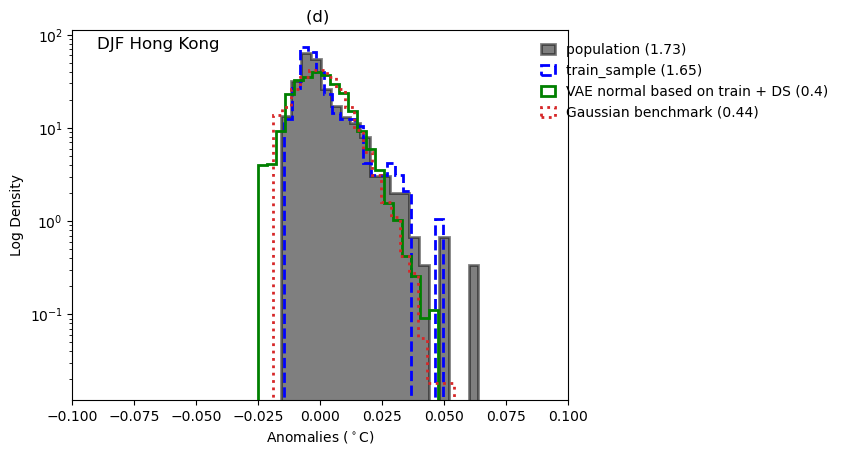

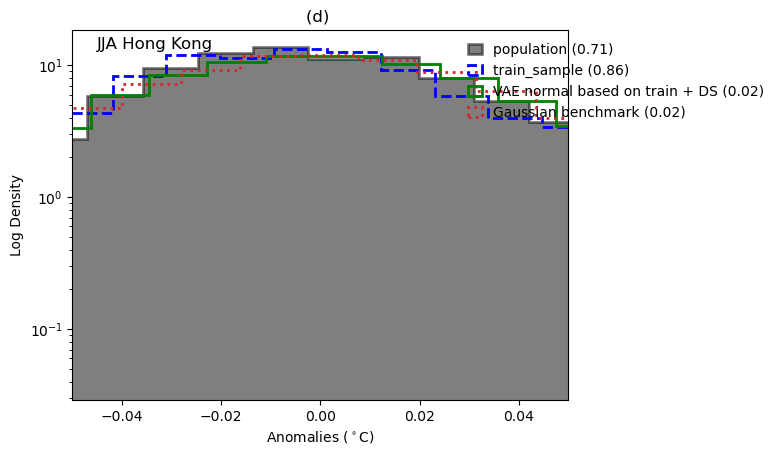

In [31]:
seasons_to_show = ['DJF', 'JJA']
# seasons_to_show = ['Full'] 

region = 'Hong Kong'
for season in seasons_to_show:
  if season == 'DJF':
        xmin=-0.1
        xmax=0.1
  else:
        xmin=-0.05
        xmax=0.05  

  
  plot_hist(['population', 'train_sample','hist_VAE2', 'hist_benchmark'],
            dict_regional_anom[region],
            dict_hist_plt,
            season=season,
             var=var,
            mean_season=mean_season,
             text_dict = {'text' : region , 'x' : 0.05, 'y' : 0.95},
            nbins=20,
            xlabel='Anomalies ($^\circ$C)',
            ylabel='Log Density',
            title='(d) ',
                fig_dir= dir_frnt_out,
            fig_name= 'Figure3_d',
            legend_bool = (True, True, True, True),
            bbox=(0.92,.5,.5,.5),
              xmin=xmin,
              xmax=xmax,
              skewness = True,
            show = True,
            save = False)

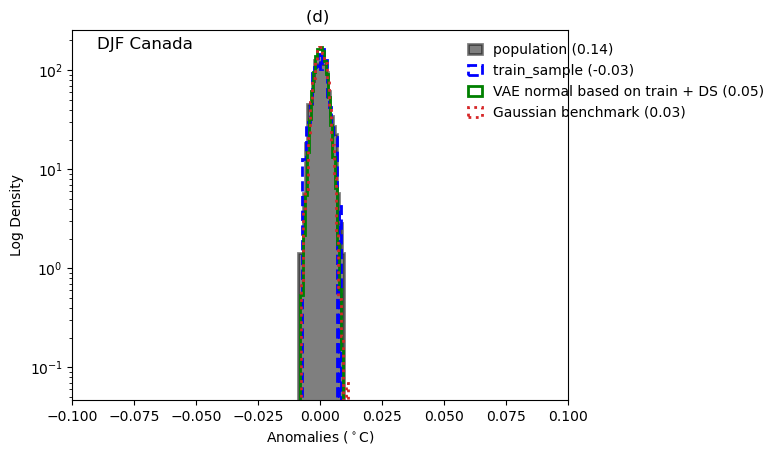

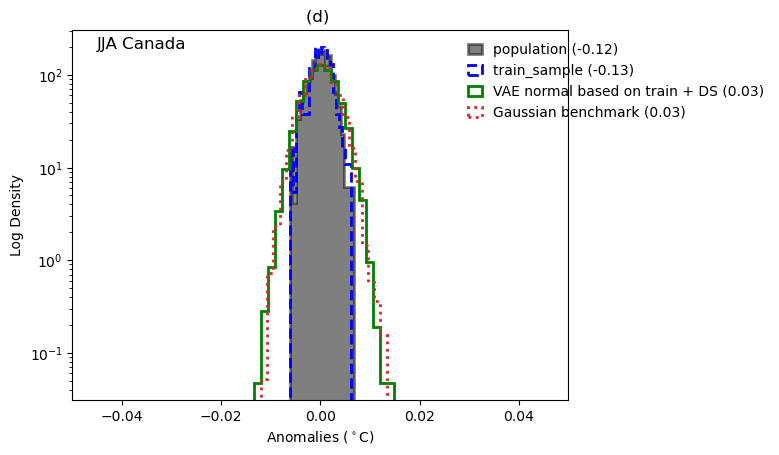

In [32]:
seasons_to_show = ['DJF', 'JJA']
# seasons_to_show = ['Full'] 

region = 'Canada'
for season in seasons_to_show:
  if season == 'DJF':
        xmin=-0.1
        xmax=0.1
  else:
        xmin=-0.05
        xmax=0.05   

  
  plot_hist(['population', 'train_sample','hist_VAE2', 'hist_benchmark'],
            dict_regional_anom[region],
            dict_hist_plt,
            season=season,
             var=var,
            mean_season=mean_season,
             text_dict = {'text' : region , 'x' : 0.05, 'y' : 0.95},
            nbins=20,
            xlabel='Anomalies ($^\circ$C)',
            ylabel='Log Density',
            title='(d) ',
                fig_dir= dir_frnt_out,
            fig_name= 'Figure3_d',
            legend_bool = (True, True, True, True),
            bbox=(0.92,.5,.5,.5),
              xmin=xmin,
              xmax=xmax,
              skewness = True,
            show = True,
            save = False)

- qq plots

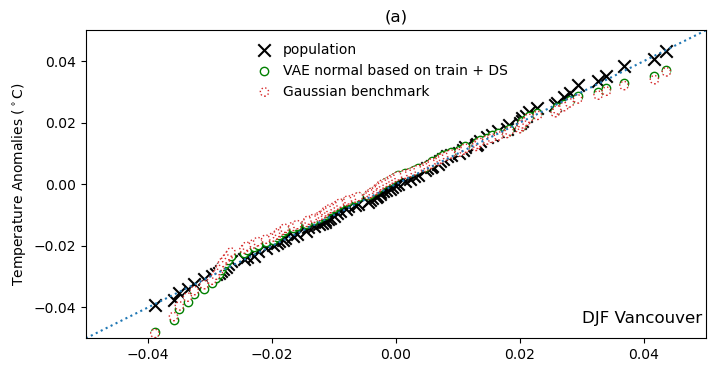

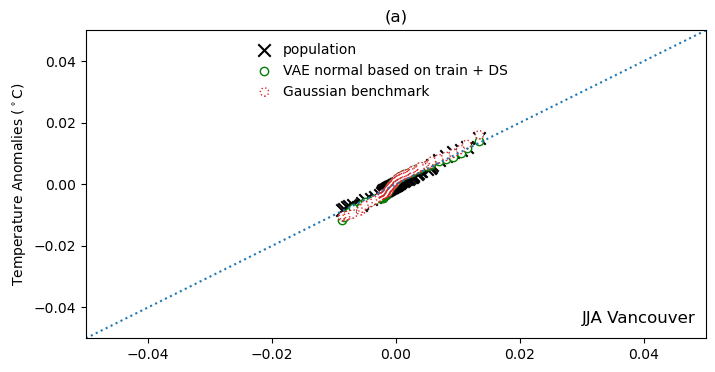

In [37]:
idata_ref = 'train_sample'
seasons_to_show = ['DJF', 'JJA']
# seasons_to_show = ['Full'] 

region = 'Vancouver'

for season in seasons_to_show:
    if season == 'DJF':
            box=[[-0.05,-0.05],
                [0.05,0.05]]
    else:
            box=[[-0.05,-0.05],
                [0.05,0.05]]
    plot_qq([key for key in ['population','hist_VAE2','hist_benchmark'] if key != idata_ref],
            dict_quantiles_flat_regional[season][region],
            idata_ref=idata_ref,
            dict_plt=dict_hist_plt,
            box=box,

                figsize=(8,4),
            bbox=(0.2,.5,.5,.5),
            title = '(a)',
            xlabel = '',
            dir_name= dir_frnt_out,
            file_name= 'Figure3_a',
             text_dict = {'text' : season + f' {region}',  'x' : 0.8, 'y' : 0.05} if season != 'Full' else   {'text' :  f'{region}',  'x' : 0.8, 'y' : 0.05},
            show=True,
            save=True)

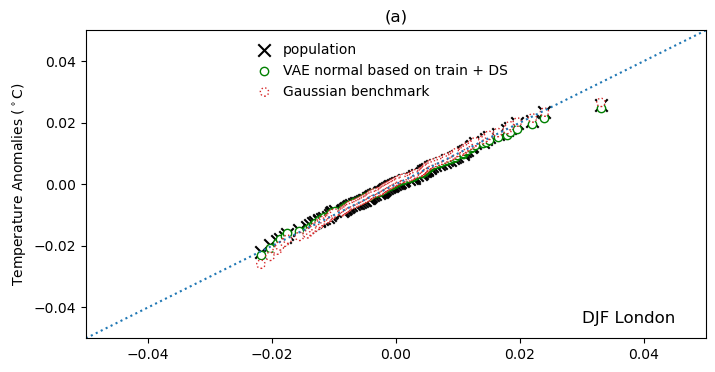

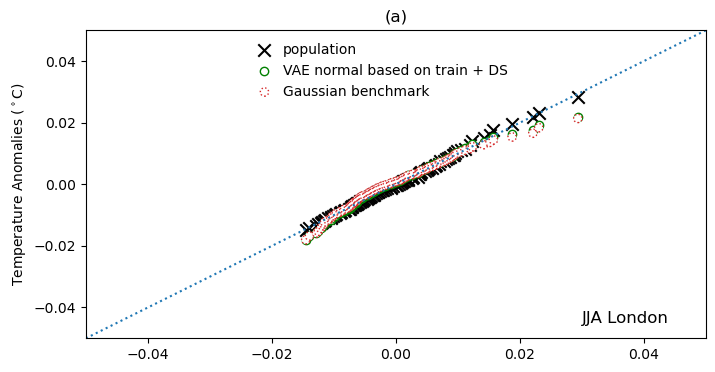

In [36]:
idata_ref = 'train_sample'
seasons_to_show = ['DJF', 'JJA']
# seasons_to_show = ['Full'] 

region = 'London'

for season in seasons_to_show:
    if season == 'DJF':
            box=[[-0.05,-0.05],
                [0.05,0.05]]
    else:
            box=[[-0.05,-0.05],
                [0.05,0.05]]
    plot_qq([key for key in ['population','hist_VAE2','hist_benchmark'] if key != idata_ref],
            dict_quantiles_flat_regional[season][region],
            idata_ref=idata_ref,
            dict_plt=dict_hist_plt,
            box=box,
                figsize=(8,4),
            bbox=(0.2,.5,.5,.5),
            title = '(a)',
            xlabel = '',
            dir_name= dir_frnt_out,
            file_name= 'Figure3_a',
             text_dict = {'text' : season + f' {region}',  'x' : 0.8, 'y' : 0.05} if season != 'Full' else   {'text' :  f'{region}',  'x' : 0.8, 'y' : 0.05},
            show=True,
            save=True)

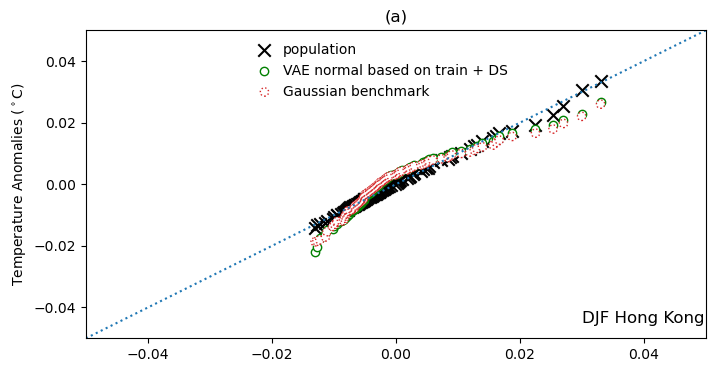

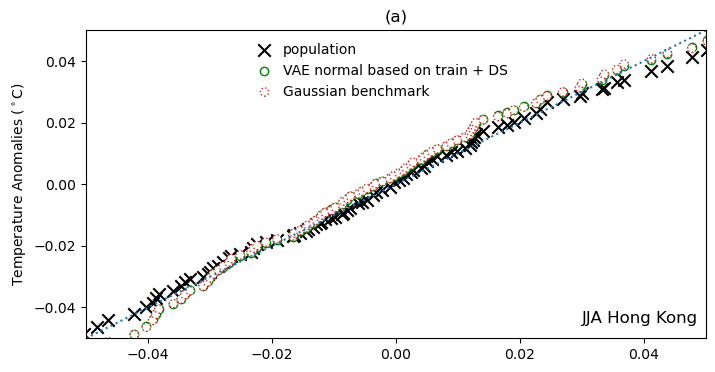

In [39]:
idata_ref = 'train_sample'
seasons_to_show = ['DJF', 'JJA']
# seasons_to_show = ['Full'] 

region = 'Hong Kong'

for season in seasons_to_show:
    if season == 'DJF':
            box=[[-0.05,-0.05],
                [0.05,0.05]]
    else:
            box=[[-0.05,-0.05],
                [0.05,0.05]]
    plot_qq([key for key in ['population','hist_VAE2','hist_benchmark'] if key != idata_ref],
            dict_quantiles_flat_regional[season][region],
            idata_ref=idata_ref,
            dict_plt=dict_hist_plt,
            box=box,
                figsize=(8,4),
            bbox=(0.2,.5,.5,.5),
            title = '(a)',
            xlabel = '',
            dir_name= dir_frnt_out,
            file_name= 'Figure3_a',
             text_dict = {'text' : season + f' {region}',  'x' : 0.8, 'y' : 0.05} if season != 'Full' else   {'text' :  f'{region}',  'x' : 0.8, 'y' : 0.05},
            show=True,
            save=True)

- time series

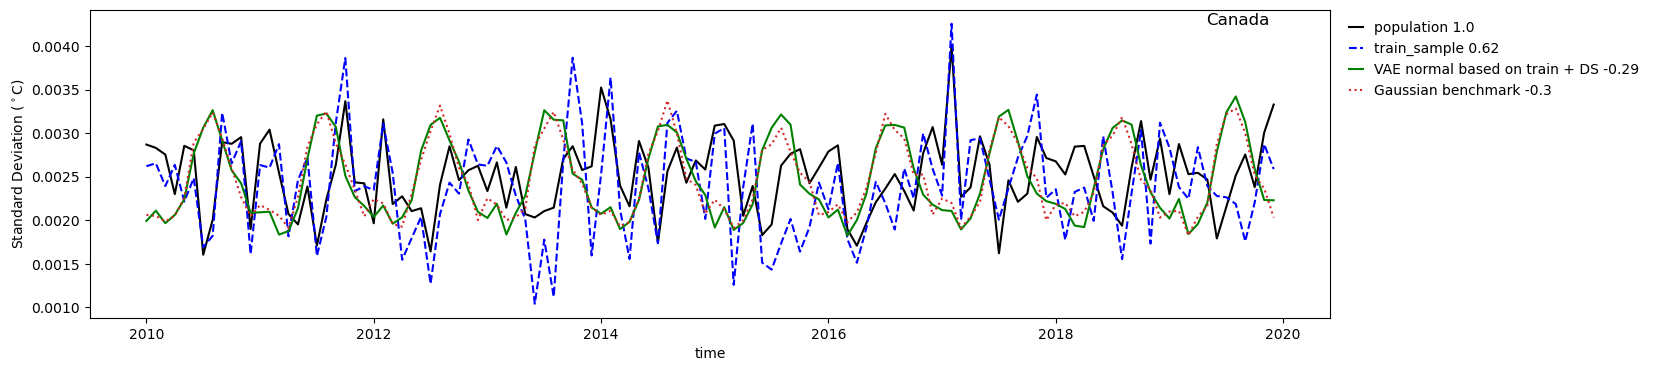

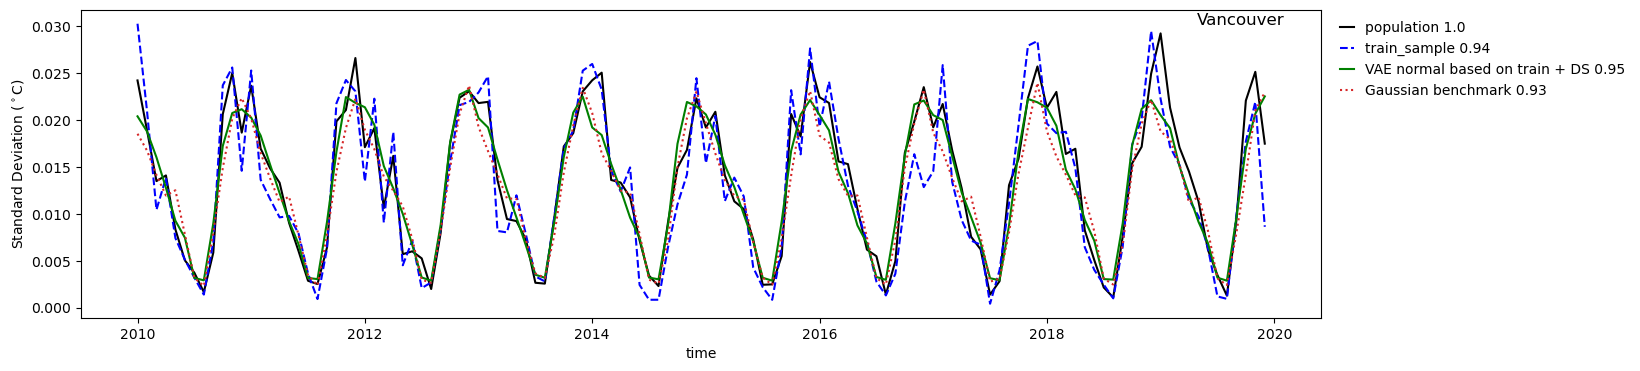

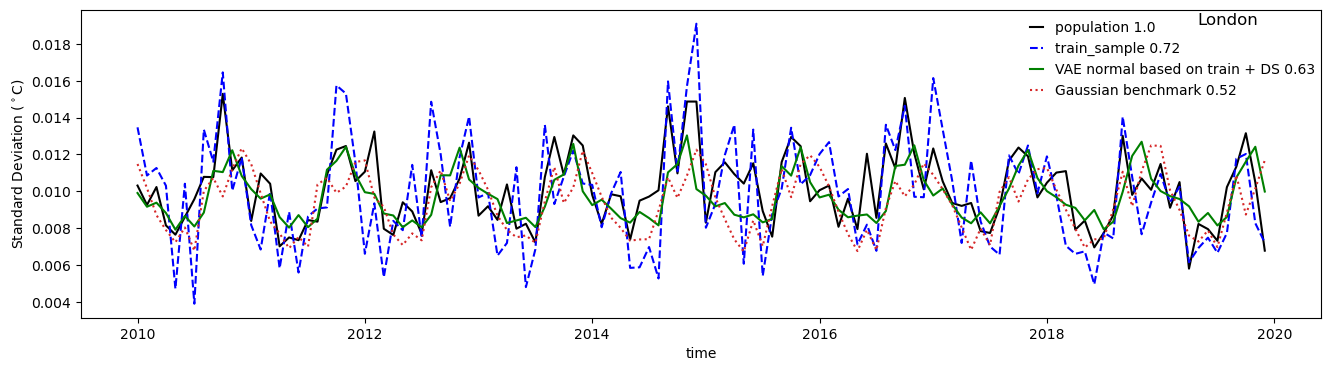

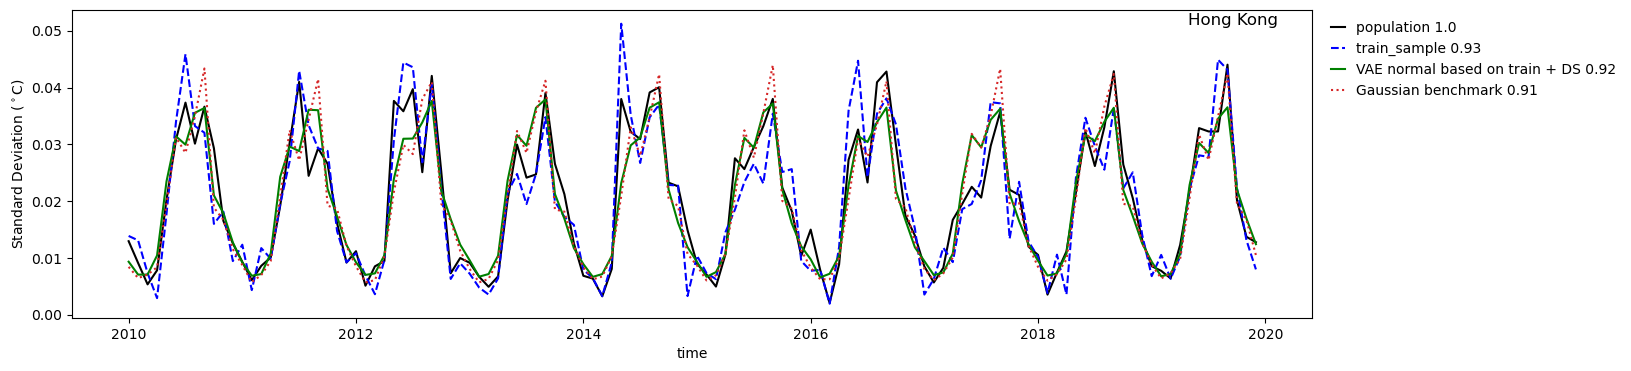

In [40]:


for region in dict_regional_anom.keys():
    plt.figure(figsize = (16,4))

    ref = dict_regional_anom[region]['population'][var].std('realization').stack(t = ('year','time')).squeeze()
    for idata, ds in dict_regional_anom[region].items():
        dstp =  ds[var].std('realization').stack(t = ('year','time')).squeeze()
        corr = xr.corr(dstp, ref).values

        plt.plot( np.arange(min(test_years),max(test_years) + 1,1/12) , 
                 dstp, 
                 label = dict_hist_plt[idata]['label'] + f' {str(np.round(corr,2))}', 
                 color  = dict_hist_plt[idata]['color'], 
                 linestyle = dict_hist_plt[idata]['linestyle'])
    plt.ylabel('Standard Deviation ($^\circ$C)')
    plt.xlabel('time')
    plt.legend()
    plt.legend(loc='best',
                bbox_to_anchor=[1.005,1.005],
                handlelength=1,
                ncol=1,
                frameon=False)  
    plt.text(0.9,0.95,region,    fontsize = 12,
        transform=plt.gca().transAxes) 

- skewness

In [41]:
from scipy.stats import skew

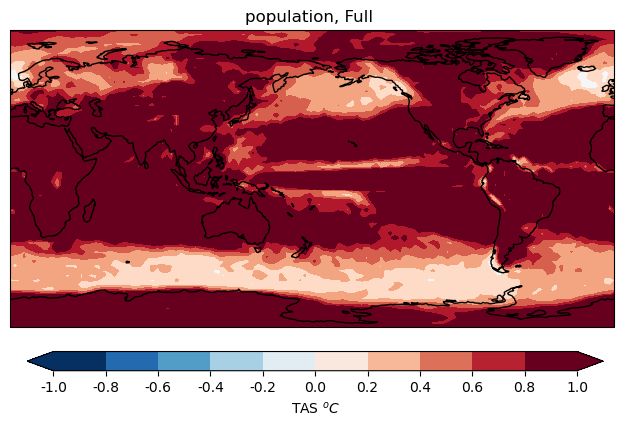

0it [00:00, ?it/s]

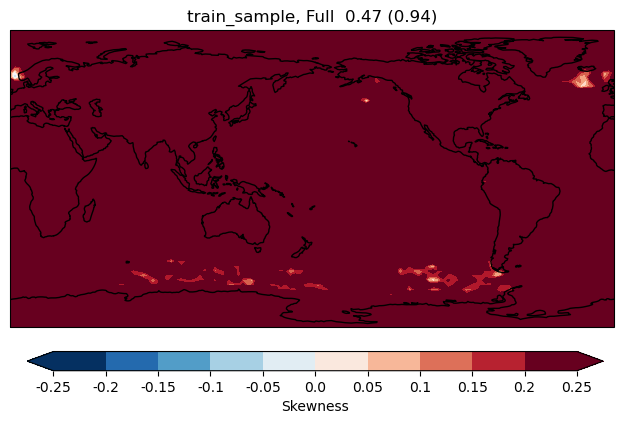

1it [00:09,  9.93s/it]

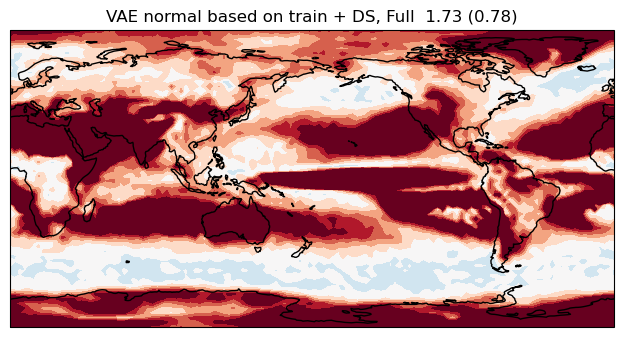

2it [00:32, 17.34s/it]

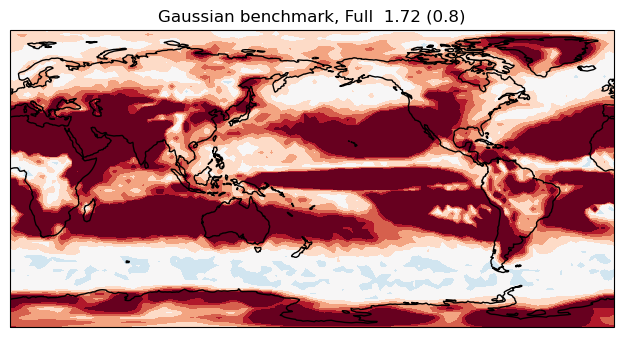

3it [00:54, 18.23s/it]


In [42]:
list_data_toplot = [ 'train_sample', 'hist_VAE2', 'hist_benchmark']
ref = 'population'

seaons_to_plot = ['Full']

for season in seaons_to_plot:
    sk = skew(dict_anom['population'][var].sel(time = dict_seasons[season]).stack(e = ('year','time','realization')), axis = -1)
    ref_ds = xr.DataArray(sk, dims = ('lat', 'lon')).assign_coords(lat = dict_anom['population'][var].lat, lon = dict_anom['population'][var].lon)

    plot_map(ref_ds,
                            title=f'{dict_hist_plt[ref]["label"]}, {season} ',
                            vmin=-1,
                            vmax=1,
                            cbar=True,
                            cbar_label = 'TAS $^{o}C$',
                            fig_dir=f'{dir_out}', 
                            # fig_name=f'Figure5_{panel}',
                            show=True,
                            save=False)    
    
    for i, idata in tqdm(enumerate(list_data_toplot)):
                
                sk = skew(dict_anom[idata][var].sel(time = dict_seasons[season]).stack(e = ('year','time','realization')), axis = -1)
                ds = xr.DataArray(sk, dims = ('lat', 'lon')).assign_coords(lat = dict_anom[idata][var].lat, lon = dict_anom[idata][var].lon)

                corr = corr_patt(ref_ds, ds).mean().values
                corr = f' ({str(np.round(corr,2))})'

                rmse = np.sqrt(((ds - ref_ds)**2).mean()).values
                rmse = f' {str(np.round(rmse,2))}'

                
                cbar = True if i == 0 else False
                plot_map((ds),
                            title=f'{dict_hist_plt[idata]["label"]}, {season} ' + rmse + corr ,
                            vmin=-0.25,
                            vmax=0.25,
                            cbar=cbar,
                            cbar_label = 'Skewness',
                            fig_dir=f'{dir_out}',
                            # fig_name=f'Figure5_{panel}',
                            show=True,
                            save=False)

- mean climate bias

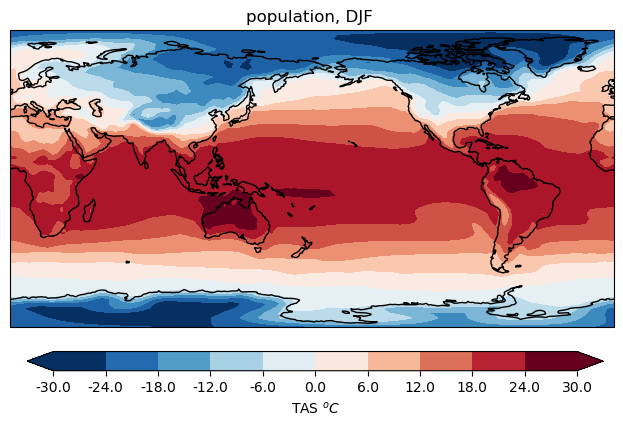

0it [00:00, ?it/s]

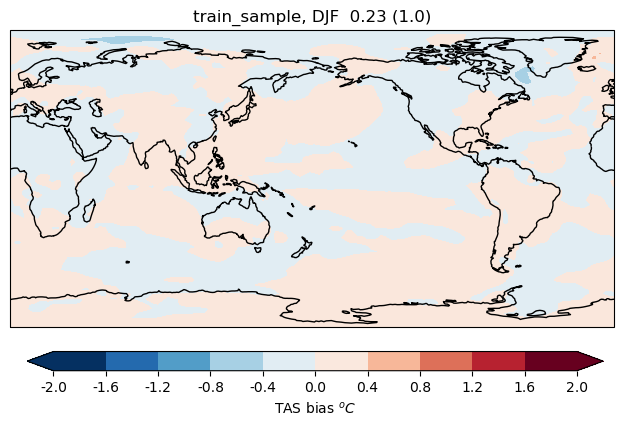

1it [00:42, 42.10s/it]

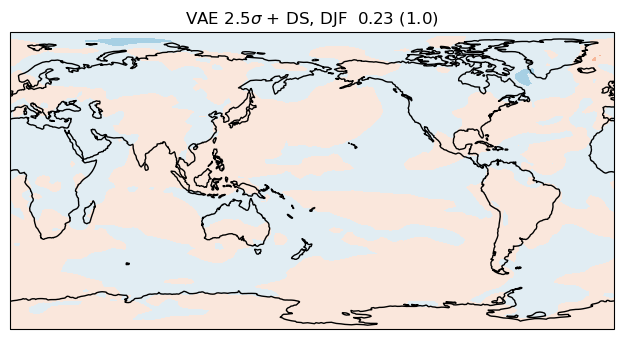

2it [02:12, 66.22s/it]


KeyboardInterrupt: 

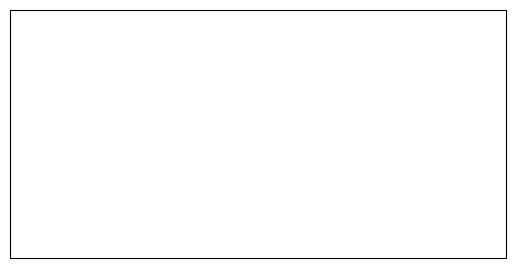

In [ ]:
# from modules.util_analysis import corr_patt
list_data_toplot = [ 'train_sample', 'hist_VAE2', 'hist_benchmark']
ref = 'population'

seaons_to_plot = ['DJF','JJA']

for season in seaons_to_plot:
    ref_ds = dict_data[ref][var].sel(time = dict_seasons[season]).mean(['time','realization']) - 273.15
    plot_map(ref_ds.mean('year'),
                            title=f'{dict_hist_plt[ref]["label"]}, {season} ',
                            vmin=-30,
                            vmax=30,
                            cbar=True,
                            cbar_label = 'TAS $^{o}C$',
                            fig_dir=f'{dir_out}', 
                            # fig_name=f'Figure5_{panel}',
                            show=True,
                            save=False)    
    
    for i, idata in tqdm(enumerate(list_data_toplot)):
    
                ds = dict_data[idata][var].sel(time = dict_seasons[season]).mean(['time','realization']) - 273.15

                corr = corr_patt(ref_ds, ds).mean().values
                corr = f' ({str(np.round(corr,2))})'

                rmse = np.sqrt(((ds - ref_ds)**2).mean('year')).mean().values
                rmse = f' {str(np.round(rmse,2))}'

                
                cbar = True if i == 0 else False
                plot_map((ds - ref_ds).mean('year'),
                            title=f'{dict_hist_plt[idata]["label"]}, {season} ' + rmse + corr ,
                            vmin=-2,
                            vmax=2,
                            cbar=cbar,
                            cbar_label = 'TAS bias $^{o}C$',
                            fig_dir=f'{dir_out}',
                            # fig_name=f'Figure5_{panel}',
                            show=True,
                            save=False)


- Temperature Extremes

In [ ]:

from tqdm import tqdm

In [ ]:
seaons_to_plot = ['DJF', 'JJA']
quantiles_toplot = [0.01, 0.99]
dict_extremes = {}

for idata in tqdm(list_data):
    dict_extremes[idata] = {}
    for season in seaons_to_plot:
        dict_extremes[idata][season] = {}
        for qq in [qq for qq in quantiles_toplot if qq != 'None']:
            if idata not in ['obs']:
                dict_extremes[idata][season][qq] = xr.DataArray(np.quantile(dict_anom[idata][var].sel(time = dict_seasons[season]).stack(ens = ('year','realization','time')).squeeze().dropna('ens'), qq, axis = -1),dims=('lat', 'lon'),coords={'lat' : dict_anom[idata].coords['lat'], 'lon' : dict_anom[idata].coords['lon']})
            else:
                dict_extremes[idata][season][qq] = xr.DataArray(np.quantile(dict_anom[idata][var].sel(time = dict_seasons[season]).stack(ens = ('year','time')).squeeze().dropna('ens'), qq, axis = -1),dims=('lat', 'lon'),coords={'lat' : dict_anom[idata].coords['lat'], 'lon' : dict_anom[idata].coords['lon']})

100%|██████████| 4/4 [01:42<00:00, 25.61s/it]


  0%|          | 0/4 [00:00<?, ?it/s]

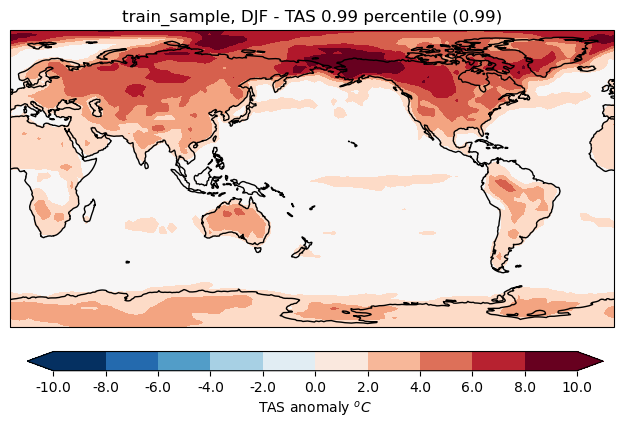

 25%|██▌       | 1/4 [00:00<00:00,  3.49it/s]

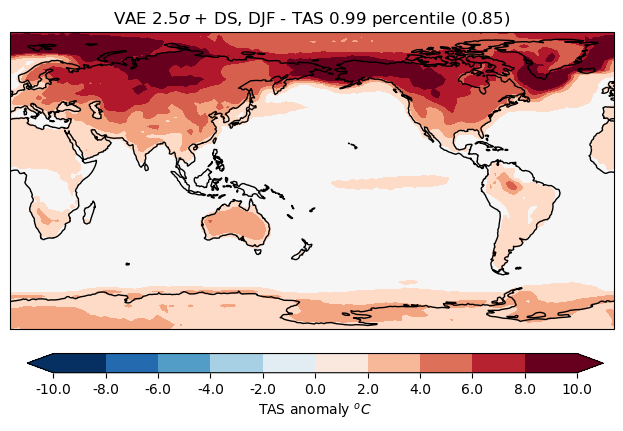

 50%|█████     | 2/4 [00:00<00:00,  3.63it/s]

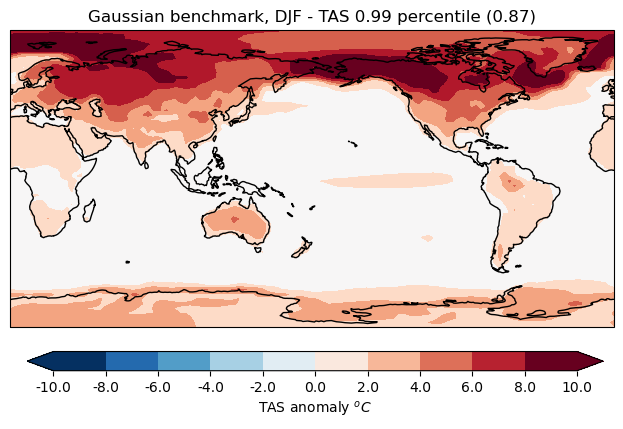

 75%|███████▌  | 3/4 [00:00<00:00,  3.81it/s]

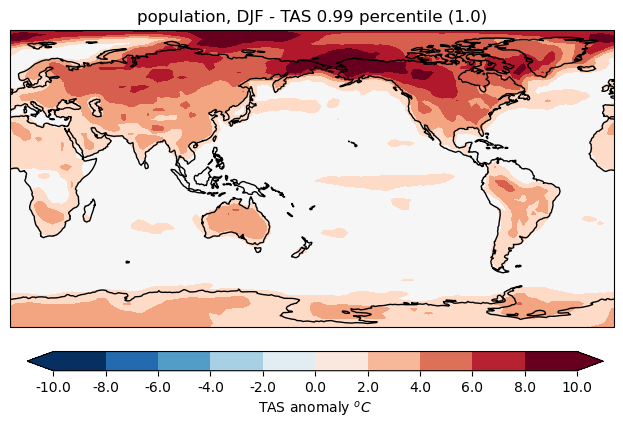

  0%|          | 0/4 [00:00<?, ?it/s]

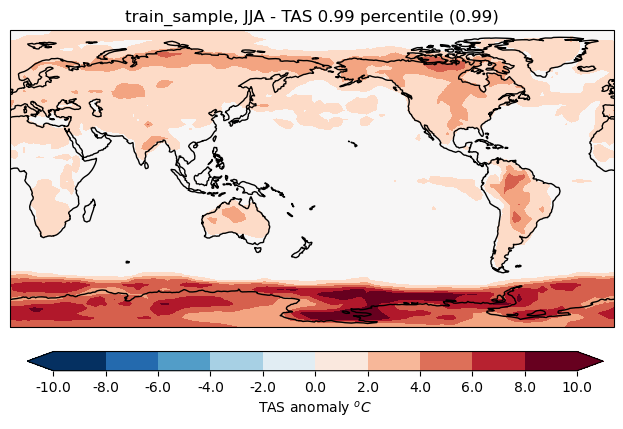

 25%|██▌       | 1/4 [00:00<00:00,  3.57it/s]

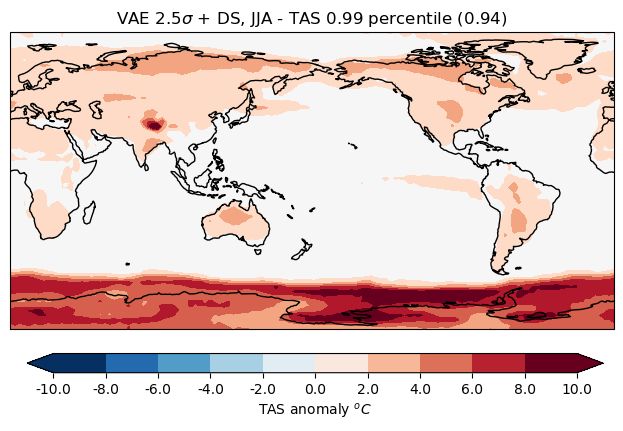

 50%|█████     | 2/4 [00:00<00:00,  3.69it/s]

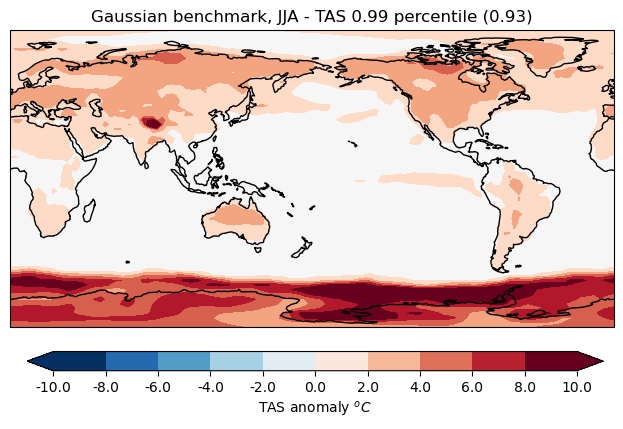

 75%|███████▌  | 3/4 [00:00<00:00,  3.82it/s]

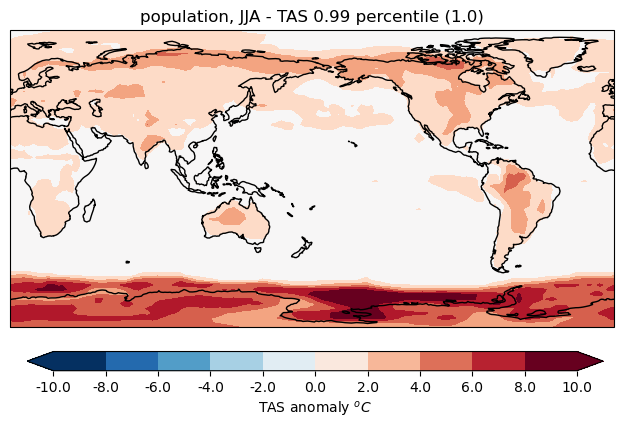

100%|██████████| 4/4 [00:01<00:00,  3.76it/s]


In [ ]:
# from modules.util_analysis import corr_patt
list_data_toplot = [ 'train_sample', 'hist_VAE2', 'hist_benchmark','population']
quantile = 0.99

for season in seaons_to_plot:
    for idata in tqdm(list_data_toplot):
    
        # for panel, qq in zip(['a','b','c'], ['0.75','0.85','None']):
            try:
                ds = dict_extremes[idata][season][quantile]
                if 'population' in list_data_toplot : 
                    ref = dict_extremes['population'][season][quantile]
                    corr = str(np.round(corr_patt(ref, ds).values,2))
                    corr = f' ({corr})'
                else:
                    corr = ''
                
                cbar = True #if panel == 'c' else False
                plot_map(ds,
                            title=f'{dict_hist_plt[idata]["label"]}, {season} - TAS {quantile} percentile' + corr,
                            vmin=-10,
                            vmax=10,
                            cbar=cbar,
                            cbar_label = 'TAS anomaly $^{o}C$',
                            fig_dir=f'{dir_out}',
                            # fig_name=f'Figure5_{panel}',
                            show=True,
                            save=False)
            except:
                    print(f'{qq} quantile for {idata} non-existent!')

  0%|          | 0/4 [00:00<?, ?it/s]

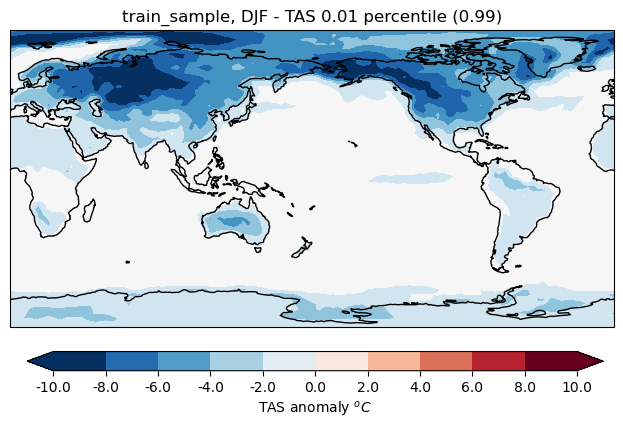

 25%|██▌       | 1/4 [00:00<00:00,  3.67it/s]

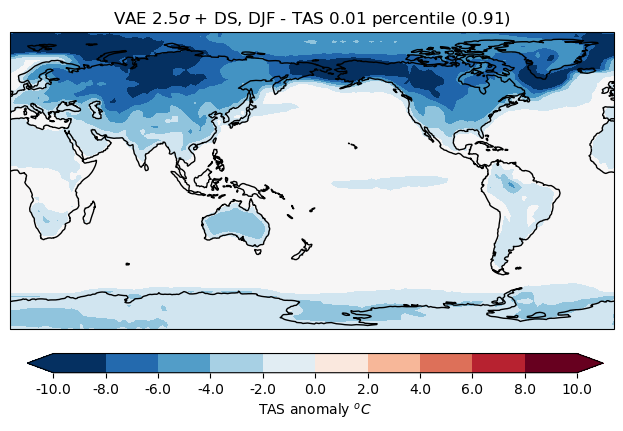

 50%|█████     | 2/4 [00:00<00:00,  2.40it/s]

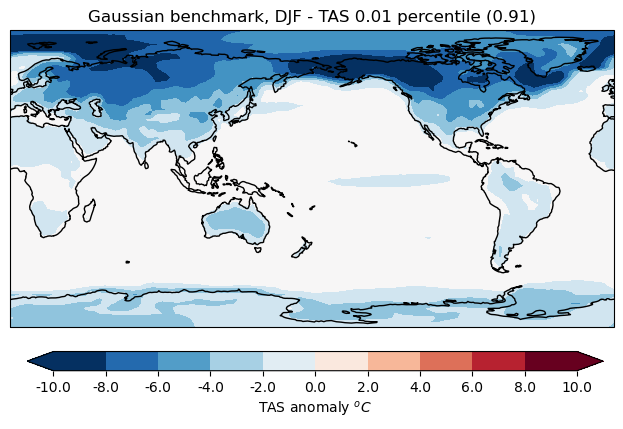

 75%|███████▌  | 3/4 [00:01<00:00,  2.96it/s]

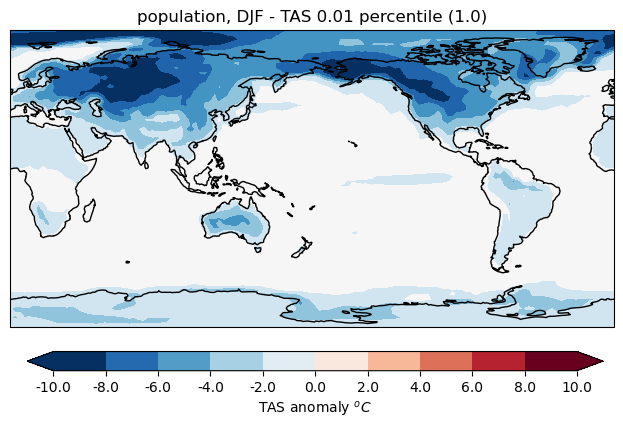

  0%|          | 0/4 [00:00<?, ?it/s]

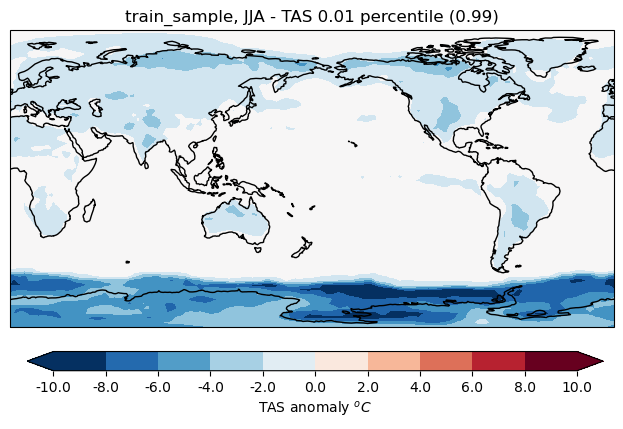

 25%|██▌       | 1/4 [00:00<00:00,  3.65it/s]

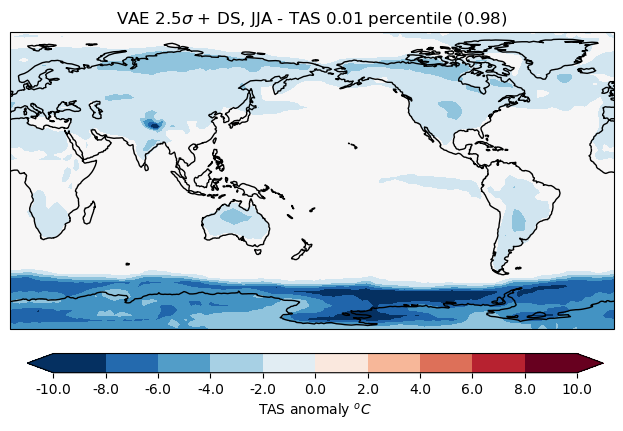

 50%|█████     | 2/4 [00:00<00:00,  3.67it/s]

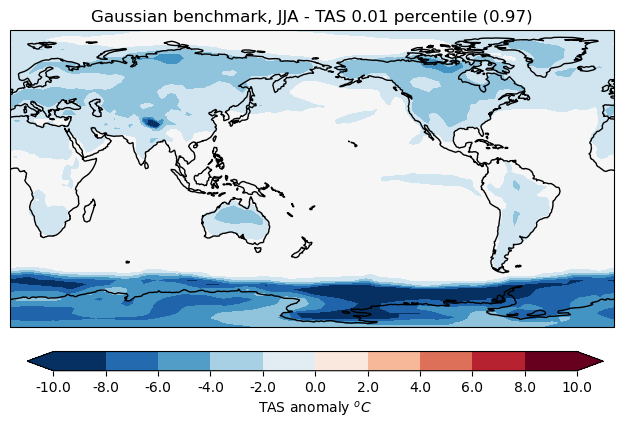

 75%|███████▌  | 3/4 [00:00<00:00,  3.81it/s]

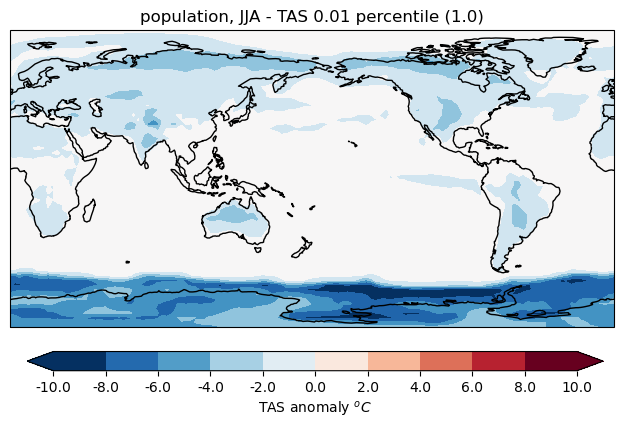

100%|██████████| 4/4 [00:01<00:00,  3.76it/s]


In [ ]:
list_data_toplot = [ 'train_sample', 'hist_VAE2', 'hist_benchmark','population']
quantile = 0.01

for season in seaons_to_plot:
    for idata in tqdm(list_data_toplot):
    
        # for panel, qq in zip(['a','b','c'], ['0.75','0.85','None']):
            try:

                ds = dict_extremes[idata][season][quantile]

                if 'population' in list_data_toplot : 
                    ref = dict_extremes['population'][season][quantile]
                    corr = str(np.round(corr_patt(ref, ds).values,2))
                    corr = f' ({corr})'
                else:
                    corr = ''

                cbar = True #if panel == 'c' else False
                plot_map(ds,
                            title=f'{dict_hist_plt[idata]["label"]}, {season} - TAS {quantile} percentile' + corr,
                            vmin=-10,
                            vmax=10,
                            cbar=cbar,
                            cbar_label = 'TAS anomaly $^{o}C$',
                            fig_dir=f'{dir_out}',
                            # fig_name=f'Figure5_{panel}',
                            show=True,
                            save=False)
            except:
                    print(f'{qq} quantile for {idata} non-existent!')

- Nino 3.4 Extremes

In [43]:

from tqdm import tqdm

dict_enso_extremes = {}
dict_enso_extremes['nino'] = {}
dict_enso_extremes['nina'] = {}
for idata in tqdm(list_data):
    dict_enso_extremes['nino'][idata] = {}
    dict_enso_extremes['nina'][idata] = {}
    for qq in [qq for qq in quantiles_enso if qq != 'None']:
        (dict_enso_extremes['nino'][idata][qq], 
         dict_enso_extremes['nina'][idata][qq]) = enso_extremes(dict_anom[idata][var].load(),
                                                                dict_enso[idata][var].load(),
                                                                dict_enso['train_sample'][var].load(),
                                                                quantile=float(qq))    

100%|██████████| 4/4 [01:52<00:00, 28.25s/it]


In [44]:
for idata in tqdm([key for key in list_data if key != 'train_sample']):
    (dict_enso_extremes['nino'][idata]['None'], 
     dict_enso_extremes['nina'][idata]['None'])  = enso_extremes(dict_anom[idata][var].load(),
                                                                 dict_enso[idata][var].load(),
                                                                 dict_enso['train_sample'][var].load(),
                                                                 quantile=None)    

100%|██████████| 3/3 [00:02<00:00,  1.18it/s]


- Nino 3.4 Extremes (Mean and StdDev)

In [45]:
dict_enso_extremes_mean = {}
dict_enso_extremes_std  = {}
for event in events:
    dict_enso_extremes_mean[event] = {}
    dict_enso_extremes_std[event]  = {}
    for idata in list_data:
        dict_enso_extremes_mean[event][idata] = {}
        dict_enso_extremes_std[event][idata]  = {}
        for qq in quantiles_enso:
            dict_enso_extremes_mean[event][idata][qq] = {}
            dict_enso_extremes_std[event][idata][qq]  = {}

In [46]:

for event in dict_enso_extremes.keys():
    for idata in list_data:
        dimension = ['realization','year']
        if idata in ['obs']:
            dimension = ['year']
        for qq in [qq for qq in quantiles_enso if qq != 'None']:

            dict_enso_extremes_mean[event][idata][qq] = dict_enso_extremes[event][idata][qq].mean(dimension)
            dict_enso_extremes_std[event][idata][qq]  = dict_enso_extremes[event][idata][qq].std(dimension)



In [47]:
qq = 'None'
time_to_show = np.arange(1,13)
for event in dict_enso_extremes.keys():
    for idata in [key for key in list_data if key != 'train_sample']:
        dimension = ['realization','year','time']
        if idata in ['obs']:
            dimension = ['year','time']


        dict_enso_extremes_mean[event][idata][qq]= dict_enso_extremes[event][idata][qq].sel(time=time_to_show).mean(dimension)
        dict_enso_extremes_std[event][idata][qq] = dict_enso_extremes[event][idata][qq].sel(time=time_to_show).std(dimension)


- Figure 5: Mean Extreme Maps

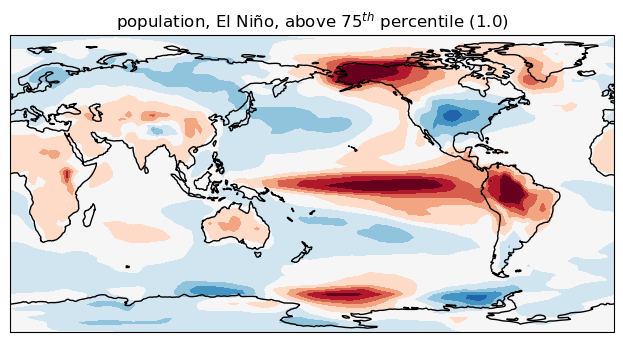

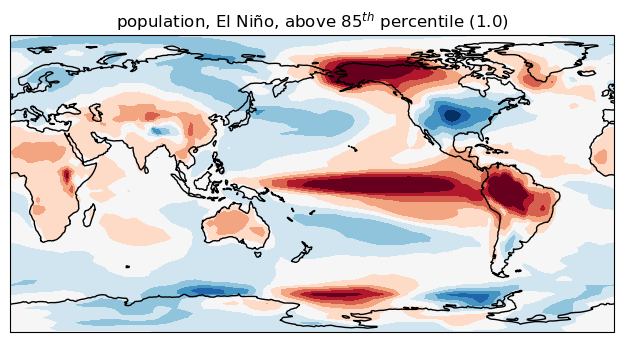

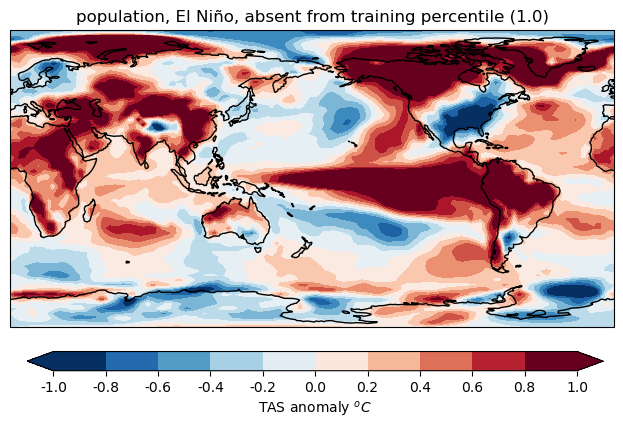

In [48]:
time_to_show = np.arange(1,13) #[1]
event = 'nino'
idata = 'population'

for panel, qq in zip(['a','b','c'], ['0.75','0.85','None']):
    try:
        if qq != 'None':
            ds = dict_enso_extremes_mean[event][idata][qq].sel(time=time_to_show).mean('time')
            ref = dict_enso_extremes_mean[event]['population'][qq].sel(time=time_to_show).mean('time')
            quantile =  'above ' + str(int(eval(qq) *100)) + r'$^{th}$'
        else:
            ds = dict_enso_extremes_mean[event][idata][qq]
            ref = dict_enso_extremes_mean[event]['population'][qq]
            quantile = 'absent from training'


        corr = np.round(corr_patt(ds, ref).values, 2)
        
        cbar = True if panel == 'c' else False
        plot_map(ds,
                    title=f'{dict_hist_plt[idata]["label"]}, El Niño, {quantile} percentile ({str(corr)})',
                    vmin=dict_event_plt[event]['mean_vmin'],
                    vmax=dict_event_plt[event]['mean_vmax'],
                    cbar=cbar,
                    cbar_label = 'TAS anomaly $^{o}C$',
                    fig_dir=f'{dir_out}',
                    fig_name=f'Figure5_{panel}',
                    show=True,
                    save=False)
    except:
            print(f'{qq} quantile El Niño for {idata} non-existent!')

None quantile nino for train_sample non-existent!


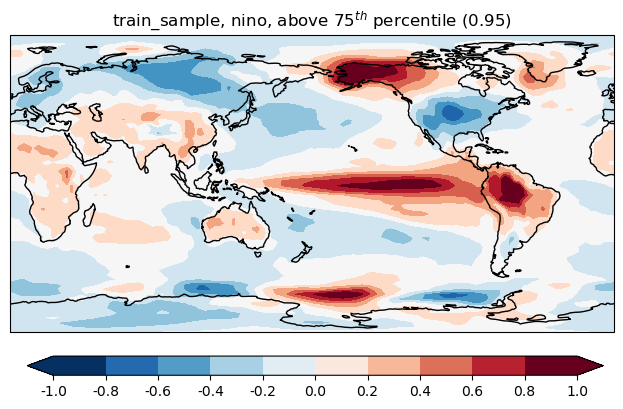

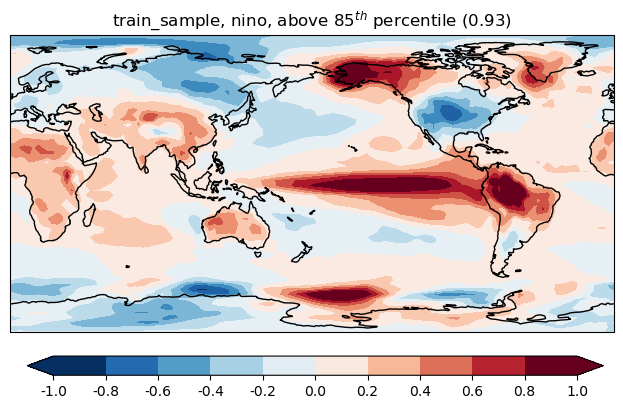

In [49]:
time_to_show = np.arange(1,13) #[1]
event = 'nino'
idata = 'train_sample'

for qq in quantiles_enso:
    try:
        if qq != 'None':
            ds = dict_enso_extremes_mean[event][idata][qq].sel(time=time_to_show).mean('time')
            ref = dict_enso_extremes_mean[event]['population'][qq].sel(time=time_to_show).mean('time')
            quantile =  'above ' + str(int(eval(qq) *100)) + r'$^{th}$'
        else:
            ds = dict_enso_extremes_mean[event][idata][qq]
            ref = dict_enso_extremes_mean[event]['population'][qq]
            quantile = 'absent from training'


        corr = np.round(corr_patt(ds, ref).values, 2)
            
        plot_map(ds,
                    title=f'{dict_hist_plt[idata]["label"]}, {event}, {quantile} percentile ({str(corr)})',
                    vmin=dict_event_plt[event]['mean_vmin'],
                    vmax=dict_event_plt[event]['mean_vmax'],
                    cbar=True,
                    fig_dir=f'{dir_out}',
                    fig_name=f'map_mean_{dict_hist_plt[idata]["label"]}_{event}_N{qq[2:4]}',
                    show=True,
                    save=False)
    except:
            print(f'{qq} quantile {event} for {idata} non-existent!')

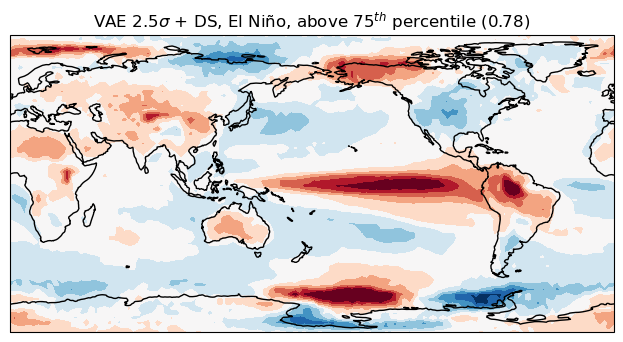

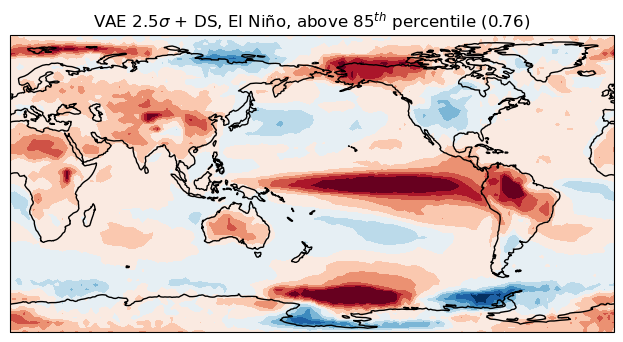

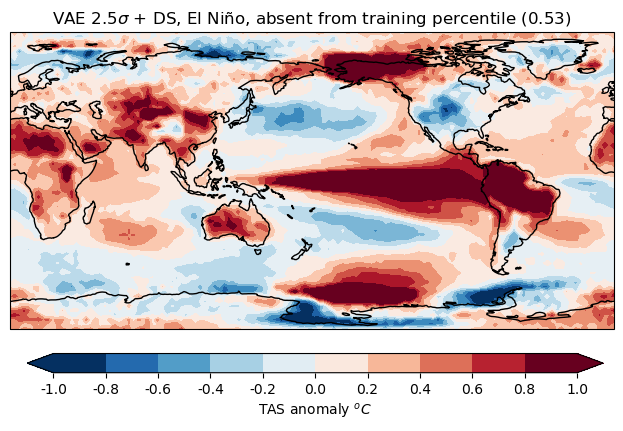

In [51]:
time_to_show = np.arange(1,13) #[1]
event = 'nino'
idata = 'hist_VAE1'

for panel, qq in zip(['a','b','c'], ['0.75','0.85','None']):
    # try:
        if qq != 'None':
            ds = dict_enso_extremes_mean[event][idata][qq].sel(time=time_to_show).mean('time')
            ref = dict_enso_extremes_mean[event]['population'][qq].sel(time=time_to_show).mean('time')
            quantile =  'above ' + str(int(eval(qq) *100)) + r'$^{th}$'
        else:
            ds = dict_enso_extremes_mean[event][idata][qq]
            ref = dict_enso_extremes_mean[event]['population'][qq]
            quantile = 'absent from training'
        cbar = True if panel == 'c' else False
        corr = np.round(corr_patt(ds, ref).values, 2)

        plot_map(ds,
                    title=f'{dict_hist_plt[idata]["label"]}, El Niño, {quantile} percentile ({str(corr)})',
                    vmin=dict_event_plt[event]['mean_vmin'],
                    vmax=dict_event_plt[event]['mean_vmax'],
                    cbar=cbar,
                    fig_dir=f'{dir_out}',
                    fig_name=f'FigureS7_{panel}',
                    cbar_label = 'TAS anomaly $^{o}C$',
                    show=True,
                    save=True)
    # except:
    #         print(f'{qq} quantile {event} for {idata} non-existent!')

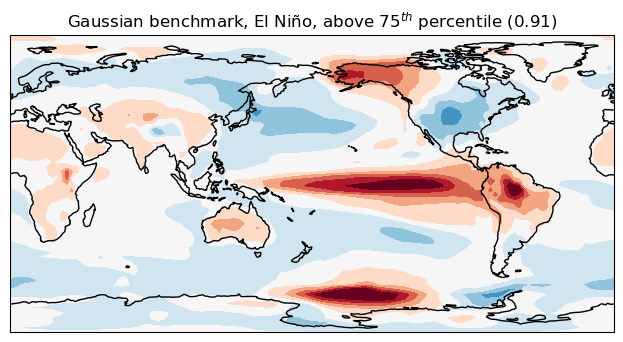

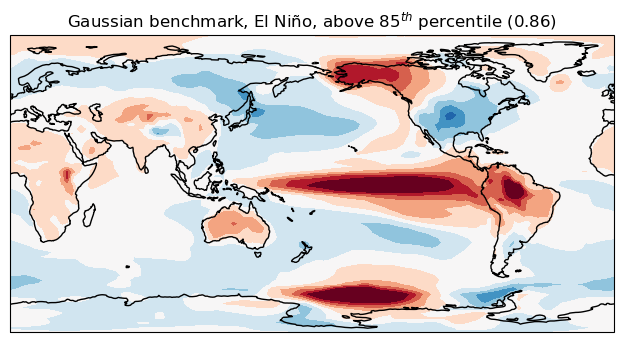

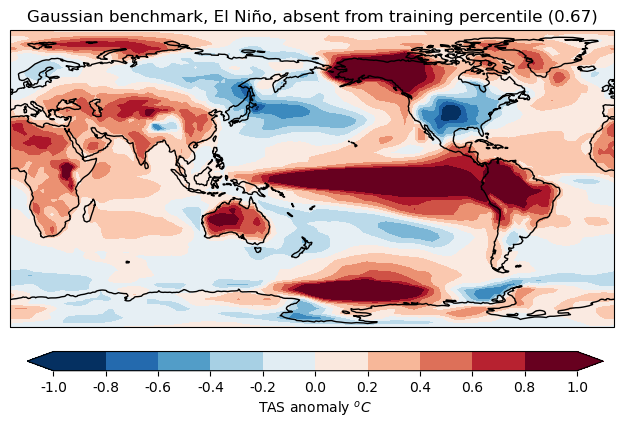

In [ ]:
time_to_show = np.arange(1,13) #[1]
event = 'nino'
idata = 'hist_benchmark'

for panel, qq in zip(['a','b','c'], ['0.75','0.85','None']):
    # try:
        if qq != 'None':
            ds = dict_enso_extremes_mean[event][idata][qq].sel(time=time_to_show).mean('time')
            ref = dict_enso_extremes_mean[event]['population'][qq].sel(time=time_to_show).mean('time')
            quantile =  'above ' + str(int(eval(qq) *100)) + r'$^{th}$'
        else:
            ds = dict_enso_extremes_mean[event][idata][qq]
            ref = dict_enso_extremes_mean[event]['population'][qq]
            quantile = 'absent from training'
        cbar = True if panel == 'c' else False
        corr = np.round(corr_patt(ds, ref).values, 2)

        plot_map(ds,
                    title=f'{dict_hist_plt[idata]["label"]}, El Niño, {quantile} percentile ({str(corr)})',
                    vmin=dict_event_plt[event]['mean_vmin'],
                    vmax=dict_event_plt[event]['mean_vmax'],
                    cbar=cbar,
                    fig_dir=f'{dir_out}',
                    fig_name=f'FigureS7_{panel}',
                    cbar_label = 'TAS anomaly $^{o}C$',
                    show=True,
                    save=True)
    # except:
    #         print(f'{qq} quantile {event} for {idata} non-existent!')

In [ ]:
# time_to_show = np.arange(1,13) #[1]
# event = 'nino'
# idata = 'clm_cVAE3'

# for panel, qq in zip(['d','e','f'], ['0.75','0.85','None']):
#     try:
#         if qq != 'None':
#             ds = dict_enso_extremes_mean[event][idata][qq].sel(time=time_to_show).mean('time')
#             quantile =  'above ' + str(int(eval(qq) *100)) + r'$^{th}$'
#         else:
#             ds = dict_enso_extremes_mean[event][idata][qq]
#             quantile = 'absent from training'
#         cbar = True if panel == 'f' else False
#         plot_map(ds,
#                     title=f'{dict_clm_plt[idata]["label"]}, El Niño, {quantile} percentile',
#                     vmin=dict_event_plt[event]['mean_vmin'],
#                     vmax=dict_event_plt[event]['mean_vmax'],
#                     cbar=cbar,
#                     fig_dir=f'{dir_out}',
#                     fig_name=f'Figure5_{panel}',
#                     cbar_label = 'TAS anomaly $^{o}C$',
#                     show=True,
#                     save=True)
#     except:
#             print(f'{qq} quantile {event} for {idata} non-existent!')

- Figure 6: Standard Deviation Extreme Maps

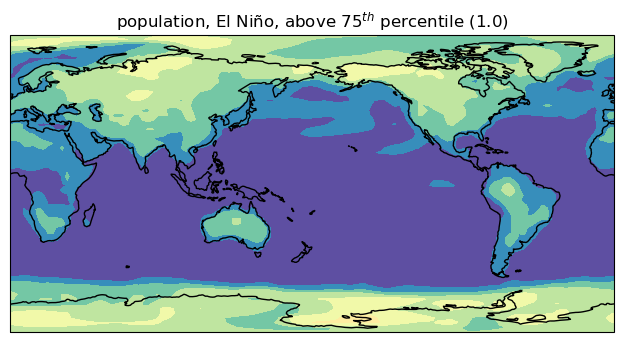

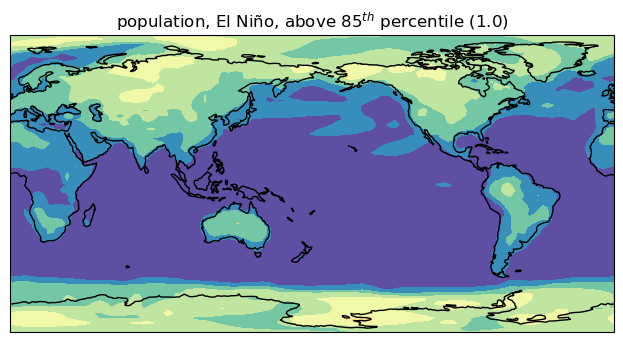

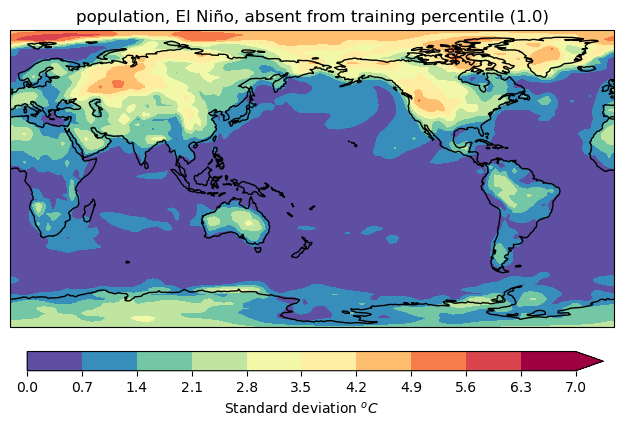

In [ ]:
time_to_show = np.arange(1,13) #[1]
event = 'nino'
idata = 'population'
for panel, qq in zip(['a','b','c'], ['0.75','0.85','None']):
    try:
        if qq != 'None':
            ds = dict_enso_extremes_std[event][idata][qq].sel(time=time_to_show).mean('time')
            ref = dict_enso_extremes_std[event]['population'][qq].sel(time=time_to_show).mean('time')
            quantile =  'above ' + str(int(eval(qq) *100)) + r'$^{th}$'
        else:
            ds = dict_enso_extremes_std[event][idata][qq]
            ref = dict_enso_extremes_std[event]['population'][qq]
            quantile = 'absent from training'
        cbar = True if panel == 'c' else False
        
        corr = np.round(corr_patt(ds, ref).values, 2)
        plot_map(ds,
                    title=f'{dict_hist_plt[idata]["label"]}, El Niño, {quantile} percentile ({str(corr)})',
                    vmin=dict_event_plt[event]['std_vmin'],
                    vmax=dict_event_plt[event]['std_vmax'],
                    cmap='Spectral_r',
                    cbar_extend='max',
                    cbar=cbar,
                    
                    fig_dir=f'{dir_out}',
                    fig_name=f'Figure6_{panel}',
                    cbar_label = 'Standard deviation $^{o}C$',
                    show=True,
                    save=True)
    except:
        print(f'{qq} quantile {event} for {idata} non-existent!')

In [14]:
time_to_show = np.arange(1,13) #[1]
event = 'nino'
idata = 'train_sample'
for panel, qq in zip(['a','b'], ['0.75','0.85']):
    try:
        if qq != 'None':
            ds = dict_enso_extremes_std[event][idata][qq].sel(time=time_to_show).mean('time')
            ref = dict_enso_extremes_std[event]['population'][qq].sel(time=time_to_show).mean('time')
            quantile =  'above ' + str(int(eval(qq) *100)) + r'$^{th}$'
        else:
            ds = dict_enso_extremes_std[event][idata][qq]
            ref = dict_enso_extremes_std[event]['population'][qq]
            quantile = 'absent from training'
        cbar = True if panel == 'c' else False
        
        corr = np.round(corr_patt(ds, ref).values, 2)            
        plot_map(ds,
                    title=f'{dict_hist_plt[idata]["label"]}, {event}, {qq} precentile ({str(corr)})',
                    vmin=dict_event_plt[event]['std_vmin'],
                    vmax=dict_event_plt[event]['std_vmax'],
                    cmap='Spectral_r',
                    cbar_extend='max',
                    cbar=True,
                    fig_dir=f'{dir_out}',
                    fig_name=f'map_std_{dict_hist_plt[idata]["label"]}_{event}_N{qq[2:4]}',
                    show=True,
                    save=True)
    except:
        print(f'{qq} quantile {event} for {idata} non-existent!')

0.75 quantile nino for train_sample non-existent!
0.85 quantile nino for train_sample non-existent!


In [15]:
time_to_show = np.arange(1,13) #[1]
event = 'nino'
idata = 'hist_VAE1'
for panel, qq in zip(['d','e','f'], ['0.75','0.85','None']):
    try:
        if qq != 'None':
            ds = dict_enso_extremes_std[event][idata][qq].sel(time=time_to_show).mean('time')
            ref = dict_enso_extremes_std[event]['population'][qq].sel(time=time_to_show).mean('time')
            quantile =  'above ' + str(int(eval(qq) *100)) + r'$^{th}$'
        else:
            ds = dict_enso_extremes_std[event][idata][qq]
            ref = dict_enso_extremes_std[event]['population'][qq]
            quantile = 'absent from training'
        cbar = True if panel == 'f' else False
        corr = np.round(corr_patt(ds, ref).values, 2)  

        plot_map(ds,
                    title=f'{dict_hist_plt[idata]["label"]}, El Niño, {quantile} percentile ({str(corr)})',
                    vmin=dict_event_plt[event]['std_vmin'],
                    vmax=dict_event_plt[event]['std_vmax'],
                    cmap='Spectral_r',
                    cbar_extend='max',
                    cbar=cbar,
                    fig_dir=f'{dir_out}',
                    cbar_label = 'Standard deviation $^{o}C$',
                    fig_name=f'FigureS7_{panel}',
                    show=True,
                    save=True)
    except:
        print(f'{qq} quantile {event} for {idata} non-existent!')

0.75 quantile nino for hist_VAE1 non-existent!
0.85 quantile nino for hist_VAE1 non-existent!
None quantile nino for hist_VAE1 non-existent!


In [16]:
time_to_show = np.arange(1,13) #[1]
event = 'nino'
idata = 'hist_benchmark'
for panel, qq in zip(['d','e','f'], ['0.75','0.85','None']):
    try:
        if qq != 'None':
            ds = dict_enso_extremes_std[event][idata][qq].sel(time=time_to_show).mean('time')
            ref = dict_enso_extremes_std[event]['population'][qq].sel(time=time_to_show).mean('time')
            quantile =  'above ' + str(int(eval(qq) *100)) + r'$^{th}$'
        else:
            ds = dict_enso_extremes_std[event][idata][qq]
            ref = dict_enso_extremes_std[event]['population'][qq]
            quantile = 'absent from training'
        cbar = True if panel == 'f' else False
        corr = np.round(corr_patt(ds, ref).values, 2)  

        plot_map(ds,
                    title=f'{dict_hist_plt[idata]["label"]}, El Niño, {quantile} percentile ({str(corr)})',
                    vmin=dict_event_plt[event]['std_vmin'],
                    vmax=dict_event_plt[event]['std_vmax'],
                    cmap='Spectral_r',
                    cbar_extend='max',
                    cbar=cbar,
                    fig_dir=f'{dir_out}',
                    cbar_label = 'Standard deviation $^{o}C$',
                    fig_name=f'FigureS7_{panel}',
                    show=True,
                    save=True)
    except:
        print(f'{qq} quantile {event} for {idata} non-existent!')

0.75 quantile nino for hist_benchmark non-existent!
0.85 quantile nino for hist_benchmark non-existent!
None quantile nino for hist_benchmark non-existent!


In [17]:
# time_to_show = np.arange(1,13) #[1]
# event = 'nino'
# idata = 'clm_cVAE1'
# for qq in ['None']:
#     try:
#         if qq != 'None':
#             ds = dict_enso_extremes_std[event][idata][qq].sel(time=time_to_show).mean('time')
#             quantile =  'above ' + str(int(eval(qq) *100)) + r'$^{th}$'
#         else:
#             ds = dict_enso_extremes_std[event][idata][qq]
#             quantile = 'absent from training'
#         plot_map(ds,
#                     title=f'{dict_clm_plt[idata]["label"]}, El Niño, {quantile} percentile',
#                     vmin=dict_event_plt[event]['std_vmin'],
#                     vmax=dict_event_plt[event]['std_vmax'],
#                     cmap='Spectral_r',
#                     cbar_extend='max',
#                     cbar=True,
#                     fig_dir=f'{dir_out}',
#                     fig_name=f'FigureS8_g',
#                     cbar_label = 'Standard deviation $^{o}C$',
#                     show=True,
#                     save=True)
#     except:
#         print(f'{qq} quantile {event} for {idata} non-existent!')

In [18]:
# time_to_show = np.arange(1,13) #[1]
# event = 'nino'
# idata = 'clm_cVAE2'
# for panel, qq in zip(['d','e','f'], ['0.75','0.85','None']):
#     try:
#         if qq != 'None':
#             ds = dict_enso_extremes_std[event][idata][qq].sel(time=time_to_show).mean('time')
#             quantile =  'above ' + str(int(eval(qq) *100)) + r'$^{th}$'
#         else:
#             ds = dict_enso_extremes_std[event][idata][qq]
#             quantile = 'absent from training'
#         cbar = True if panel == 'f' else False
#         plot_map(ds,
#                     title=f'{dict_clm_plt[idata]["label"]}, El Niño, {quantile} percentile',
#                     vmin=dict_event_plt[event]['std_vmin'],
#                     vmax=dict_event_plt[event]['std_vmax'],
#                     cmap='Spectral_r',
#                     cbar_extend='max',
#                     cbar=cbar,
#                     fig_dir=f'{dir_out}',
#                     fig_name=f'FigureS8_{panel}',
#                     cbar_label = 'Standard deviation $^{o}C$',
#                     show=True,
#                     save=True)
#     except:
#         print(f'{qq} quantile {event} for {idata} non-existent!')

In [104]:
# time_to_show = np.arange(1,13) #[1]
# event = 'nino'
# idata = 'clm_cVAE3'
# for panel, qq in zip(['d','e','f'], ['0.75','0.85','None']):
#     try:
#         if qq != 'None':
#             ds = dict_enso_extremes_std[event][idata][qq].sel(time=time_to_show).mean('time')
#             quantile =  'above ' + str(int(eval(qq) *100)) + r'$^{th}$'
#         else:
#             ds = dict_enso_extremes_std[event][idata][qq]
#             quantile = 'absent from training'
#         cbar = True if panel == 'f' else False
#         plot_map(ds,
#                     title=f'{dict_clm_plt[idata]["label"]}, El Niño, {quantile} percentile',
#                     vmin=dict_event_plt[event]['std_vmin'],
#                     vmax=dict_event_plt[event]['std_vmax'],
#                     cmap='Spectral_r',
#                     cbar_extend='max',
#                     cbar=cbar,
#                     fig_dir=f'{dir_out}',
#                     fig_name=f'Figure6_{panel}',
#                     cbar_label = 'Standard deviation $^{o}C$',
#                     show=True,
#                     save=True)
#     except:
#         print(f'{qq} quantile {event} for {idata} non-existent!')

- Power

In [80]:
def power(ds,num_bins = 100,
          anomalies=False):
 
    R_earth_km = 6371
    if anomalies:
        ds_anoms = ds - ds.mean(['lat','lon'])
    else:
        ds_anoms = ds.copy()
 
    # grid = pysh.SHGrid.from_array(ds_anoms)
    # coeffs = grid.expand()
    # spectrum = coeffs.spectrum(lmax=coeffs.lmax)
 
    # l_values = np.arange(1, len(spectrum))  # Degrees l start from 1 (skip l=0)
    # wavelengths_km = 2 * np.pi * R_earth_km / l_values
    fft2 = np.fft.fft2(ds_anoms)
    psd2d = np.abs(fft2)**2         # 2D power spectrum (not normalized)
    psd2d = np.fft.fftshift(psd2d) 
    n_lat, n_lon = ds_anoms.shape
    dlat = 1      # deg per pixel (change if yours is different)
    dlon = 1 
    freq_lat = np.fft.fftshift(np.fft.fftfreq(n_lat, dlat))
    freq_lon = np.fft.fftshift(np.fft.fftfreq(n_lon, dlon))

    f_lon_grid, f_lat_grid = np.meshgrid(freq_lon, freq_lat)
    freq_r = np.sqrt(f_lat_grid**2 + f_lon_grid**2)  
    freq_r_flat = freq_r.ravel()
    psd_flat = psd2d.ravel()

    if num_bins is None:
        num_bins = min(n_lat, n_lon)//2   # or, pick your preferred number of bins
    bins = np.linspace(0, np.max(freq_r), num_bins+1)
    bin_centers = 0.5*(bins[:-1] + bins[1:])

    # Calculate mean power in each radial bin
    radial_mean_power = np.zeros(num_bins)
    for i in range(num_bins):
        in_bin = (freq_r_flat >= bins[i]) & (freq_r_flat < bins[i+1])
        if np.any(in_bin):
            radial_mean_power[i] = np.mean(psd_flat[in_bin])
        else:
            radial_mean_power[i] = 0.0

    return  radial_mean_power, bin_centers


In [82]:
# from modules.util_analysis import power

list_data_toplot = ['population', 'train_sample', 'hist_VAE2', 'hist_benchmark' ]
years_to_show = np.array([2015])  #dict_data[idata].year


dict_power_data = {}

for season in seasons_to_show:
    dict_power_data[season] = {}
    for idata in tqdm(list_data_toplot):
        print(idata)
        ls_power_t = []
        # for yr in dict_data[idata].year:
        for yr in years_to_show:
            ls_power = []

            for i in tqdm(range(len(dict_data[idata].realization))):
                spectra, wavelengths_km =  power( dict_data[idata][var].sel(year = yr, time = dict_seasons[season]).mean('time').isel(realization = i).squeeze())  
                ls_power.append( spectra[None, ])

            ls_power_t.append(np.concatenate(ls_power, axis = 0)[None, ])
        
        # dict_power_data[season][idata] = xr.DataArray(np.concatenate(ls_power_t, axis = 0), dims = ('year', 'realization', 'wavelength'),
        #                                               coords= {'year' : dict_data[idata].year, 'realization' : dict_data[idata].realization,'wavelength' : wavelengths_km})  
        dict_power_data[season][idata] = xr.DataArray(np.concatenate(ls_power_t, axis = 0), dims = ('year', 'realization', 'wavelength'),
                                                      coords= {'year' : years_to_show, 'realization' : dict_data[idata].realization,'wavelength' : wavelengths_km})  


  0%|          | 0/4 [00:00<?, ?it/s]

population


 25%|██▌       | 1/4 [01:19<03:58, 79.47s/it]

train_sample


 50%|█████     | 2/4 [01:51<01:43, 51.66s/it]

hist_VAE2


 75%|███████▌  | 3/4 [04:28<01:39, 99.90s/it]

hist_benchmark


100%|██████████| 4/4 [07:04<00:00, 106.14s/it]


In [ ]:
# from modules.util_analysis import power

# list_data_toplot = [ 'hist_VAE4' ]
# years_to_show = np.array([2015])  #dict_data[idata].year


# # dict_power_data = {}

# for season in seasons_to_show:
#     # dict_power_data[season] = {}
#     for idata in (list_data_toplot):
#         print(idata)
#         ls_power_t = []
#         # for yr in dict_data[idata].year:
#         for yr in years_to_show:
#             ls_power = []

#             for i in tqdm(range(len(dict_data[idata].realization))):
#                 spectra, wavelengths_km =  power( dict_data[idata][var].sel(year = yr, time = dict_seasons[season]).mean('time').isel(realization = i).squeeze())  
#                 ls_power.append( spectra[None, ])

#             ls_power_t.append(np.concatenate(ls_power, axis = 0)[None, ])
        
#         # dict_power_data[season][idata] = xr.DataArray(np.concatenate(ls_power_t, axis = 0), dims = ('year', 'realization', 'wavelength'),
#         #                                               coords= {'year' : dict_data[idata].year, 'realization' : dict_data[idata].realization,'wavelength' : wavelengths_km})  
#         dict_power_data[season][idata] = xr.DataArray(np.concatenate(ls_power_t, axis = 0), dims = ('year', 'realization', 'wavelength'),
#                                                       coords= {'year' : years_to_show, 'realization' : dict_data[idata].realization,'wavelength' : wavelengths_km})  


  0%|          | 0/1 [00:00<?, ?it/s]

hist_VAE4


100%|██████████| 1/1 [02:36<00:00, 156.79s/it]


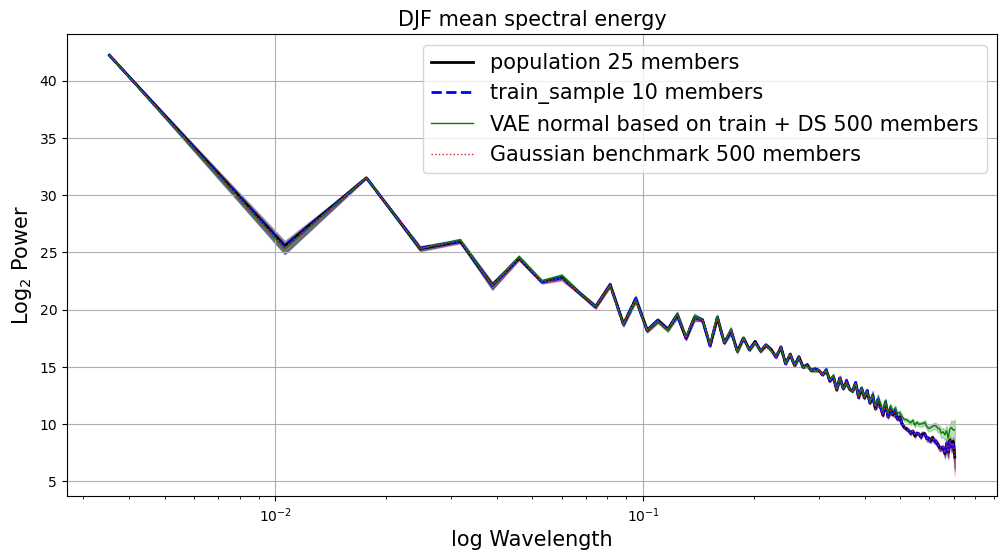

In [86]:
list_data_toplot = ['population', 'train_sample', 'hist_VAE2', 'hist_benchmark' ]

dict_plot = dict_hist_plt

for season in seasons_to_show:
    fig, ax = plt.subplots(1,1,
                           figsize=(12,6))
    for idata in list_data_toplot:

        dstp = dict_power_data[season][idata]
        ax.plot(dstp['wavelength'], np.log2(dstp.mean(['year', 'realization'])), 
                color=dict_plot[idata]['color'],
                label=f'{dict_plot[idata]["label"]} {np.prod(dstp.shape[:-1])} members',
                 linestyle = dict_plot[idata]['linestyle'],
                 linewidth = dict_plot[idata]['linewidth'])


        pwr_min = dstp.mean(['year', 'realization']) - dstp.std(['year', 'realization'])
        pwr_max = dstp.mean(['year', 'realization']) + dstp.std(['year', 'realization'])

        ax.fill_between(dstp['wavelength'],
                            np.log2(pwr_min),
                            np.log2(pwr_max),
                            alpha=.25,
                            color=dict_plot[idata]['color'])



    plt.xscale('log')
    plt.xlabel('log Wavelength', fontsize = 15)
    plt.ylabel(f'Log$_2$ Power', fontsize = 15)

    plt.grid(True)
    plt.legend( fontsize = 15)
    plt.rc('xtick',labelsize=10)
    plt.rc('ytick',labelsize=10)
    # plt.gca().invert_xaxis()  # Invert the x-axis since larger wavelengths correspond to smaller l-values
    plt.title(f'{season} mean spectral energy', fontsize = 15)
    plt.show()



In [87]:
# from modules.util_analysis import power

list_data_toplot = ['population', 'train_sample', 'hist_VAE2', 'hist_benchmark' ]
years_to_show = np.array([2015])  #dict_data[idata].year
seasons_to_show = ['DJF']

dict_power_data_anoms = {}

for season in seasons_to_show:
    dict_power_data_anoms[season] = {}
    for idata in tqdm(list_data_toplot):
        print(idata)
        ls_power_t = []
        # for yr in dict_data[idata].year:
        for yr in years_to_show:
            ls_power = []

            for i in range(len(dict_data[idata].realization)):
                spectra, wavelengths_km =  power( dict_anom[idata][var].sel(year = yr, time = dict_seasons[season]).mean('time').isel(realization = i).squeeze())  
                ls_power.append( spectra[None, ])

            ls_power_t.append(np.concatenate(ls_power, axis = 0)[None, ])
        
        # dict_power_data[season][idata] = xr.DataArray(np.concatenate(ls_power_t, axis = 0), dims = ('year', 'realization', 'wavelength'),
        #                                               coords= {'year' : dict_data[idata].year, 'realization' : dict_data[idata].realization,'wavelength' : wavelengths_km})  
        dict_power_data_anoms[season][idata] = xr.DataArray(np.concatenate(ls_power_t, axis = 0), dims = ('year', 'realization', 'wavelength'),
                                                      coords= {'year' : years_to_show, 'realization' : dict_data[idata].realization,'wavelength' : wavelengths_km})  


  0%|          | 0/4 [00:00<?, ?it/s]

population


 25%|██▌       | 1/4 [00:00<00:00,  4.41it/s]

train_sample
hist_VAE2


 75%|███████▌  | 3/4 [01:11<00:26, 26.56s/it]

hist_benchmark


100%|██████████| 4/4 [02:25<00:00, 36.28s/it]


In [ ]:
# from modules.util_analysis import power

# list_data_toplot = ['hist_VAE4' ]
# years_to_show = np.array([2015])  #dict_data[idata].year
# seasons_to_show = ['DJF']


# for season in seasons_to_show:
#     for idata in tqdm(list_data_toplot):
#         print(idata)
#         ls_power_t = []
#         # for yr in dict_data[idata].year:
#         for yr in years_to_show:
#             ls_power = []

#             for i in range(len(dict_data[idata].realization)):
#                 spectra, wavelengths_km =  power( dict_anom[idata][var].sel(year = yr, time = dict_seasons[season]).mean('time').isel(realization = i).squeeze())  
#                 ls_power.append( spectra[None, ])

#             ls_power_t.append(np.concatenate(ls_power, axis = 0)[None, ])
        
#         # dict_power_data[season][idata] = xr.DataArray(np.concatenate(ls_power_t, axis = 0), dims = ('year', 'realization', 'wavelength'),
#         #                                               coords= {'year' : dict_data[idata].year, 'realization' : dict_data[idata].realization,'wavelength' : wavelengths_km})  
#         dict_power_data_anoms[season][idata] = xr.DataArray(np.concatenate(ls_power_t, axis = 0), dims = ('year', 'realization', 'wavelength'),
#                                                       coords= {'year' : years_to_show, 'realization' : dict_data[idata].realization,'wavelength' : wavelengths_km})  


  0%|          | 0/1 [00:00<?, ?it/s]

hist_VAE4


100%|██████████| 1/1 [01:08<00:00, 68.34s/it]


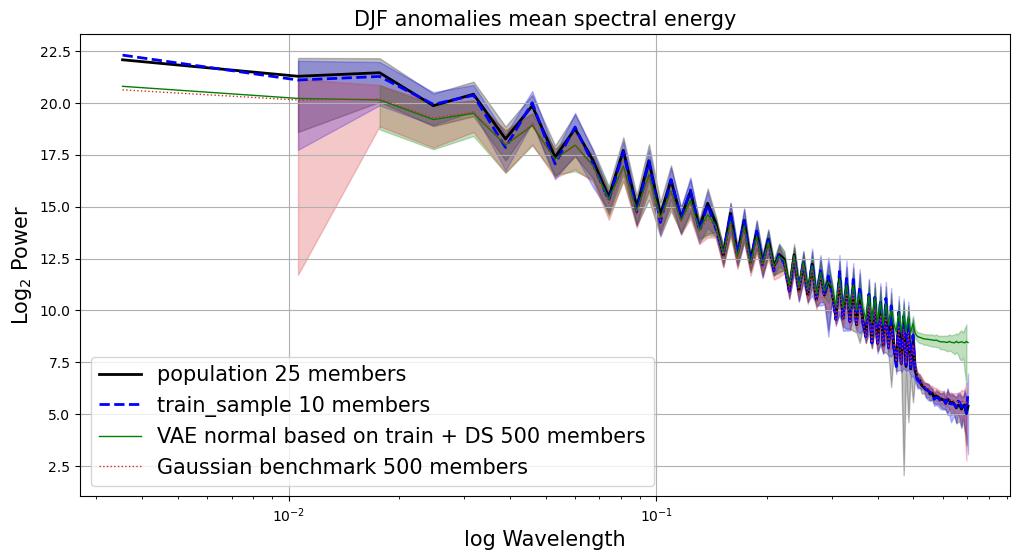

In [89]:
list_data_toplot = ['population', 'train_sample', 'hist_VAE2', 'hist_benchmark' ]

dict_plot = dict_hist_plt

for season in seasons_to_show:
    fig, ax = plt.subplots(1,1,
                           figsize=(12,6))
    for idata in list_data_toplot:

        dstp = dict_power_data_anoms[season][idata]
        ax.plot(dstp['wavelength'], np.log2(dstp.mean(['year', 'realization'])), 
                color=dict_plot[idata]['color'],
                label=f'{dict_plot[idata]["label"]} {np.prod(dstp.shape[:-1])} members',
                 linestyle = dict_plot[idata]['linestyle'],
                 linewidth = dict_plot[idata]['linewidth'])


        pwr_min = dstp.mean(['year', 'realization']) - dstp.std(['year', 'realization'])
        pwr_max = dstp.mean(['year', 'realization']) + dstp.std(['year', 'realization'])

        ax.fill_between(dstp['wavelength'],
                            np.log2(pwr_min),
                            np.log2(pwr_max),
                            alpha=.25,
                            color=dict_plot[idata]['color'])



    plt.xscale('log')
    plt.xlabel('log Wavelength', fontsize = 15)
    plt.ylabel(f'Log$_2$ Power', fontsize = 15)

    plt.grid(True)
    plt.legend( fontsize = 15)
    plt.rc('xtick',labelsize=10)
    plt.rc('ytick',labelsize=10)
    # plt.gca().invert_xaxis()  # Invert the x-axis since larger wavelengths correspond to smaller l-values
    plt.title(f'{season} anomalies mean spectral energy', fontsize = 15)
    plt.show()



- La Nina S9-10

In [ ]:
time_to_show = np.arange(1,13) #[1]
event = 'nina'
idata = 'population'

for panel, qq in zip(['a','b','c'], ['0.75','0.85','None']):
    try:
        if qq != 'None':
            ds = dict_enso_extremes_mean[event][idata][qq].sel(time=time_to_show).mean('time')
            quantile = f'{np.round(1- eval(qq),2)}'
            quantile = 'below ' + str(int(eval(quantile) *100)) + r'$^{th}$'
        else:
            ds = dict_enso_extremes_mean[event][idata][qq]
            quantile = 'absent from training'

        cbar = True if panel == 'c' else False

        plot_map(ds,
                    title=f'{dict_clm_plt[idata]["label"]}, La Niña, {quantile} percentile',
                    vmin=dict_event_plt[event]['mean_vmin'],
                    vmax=dict_event_plt[event]['mean_vmax'],
                    cbar=cbar,
                    cbar_label = 'TAS anomaly $^{o}C$',
                    fig_dir=f'{dir_out}',
                    fig_name=f'FigureS9_{panel}',
                    show=True,
                    save=True)
    except:
            print(f'{qq} quantile {event} for {idata} non-existent!')

In [ ]:
time_to_show = np.arange(1,13) #[1]
event = 'nina'
idata = 'clm_cVAE3'

for panel, qq in zip(['d','e','f'], ['0.75','0.85','None']):
    try:
        if qq != 'None':
            ds = dict_enso_extremes_mean[event][idata][qq].sel(time=time_to_show).mean('time')
            quantile = f'{np.round(1- eval(qq),2)}'
            quantile = 'below ' + str(int(eval(quantile) *100)) + r'$^{th}$'
        else:
            ds = dict_enso_extremes_mean[event][idata][qq]
            quantile = 'absent from training'
        cbar = True if panel == 'f' else False
        plot_map(ds,
                    title=f'{dict_clm_plt[idata]["label"]}, La Niña, {quantile} percentile',
                    vmin=dict_event_plt[event]['mean_vmin'],
                    vmax=dict_event_plt[event]['mean_vmax'],
                    cbar=cbar,
                    fig_dir=f'{dir_out}',
                    fig_name=f'FigureS9_{panel}',
                    cbar_label = 'TAS anomaly $^{o}C$',
                    show=True,
                    save=True)
    except:
            print(f'{qq} quantile {event} for {idata} non-existent!')

In [ ]:
time_to_show = np.arange(1,13) #[1]
event = 'nina'
idata = 'population'
for panel, qq in zip(['a','b','c'], ['0.75','0.85','None']):
    try:
        if qq != 'None':
            ds = dict_enso_extremes_std[event][idata][qq].sel(time=time_to_show).mean('time')
            quantile = f'{np.round(1- eval(qq),2)}'
            quantile = 'below ' + str(int(eval(quantile) *100)) + r'$^{th}$'
        else:
            ds = dict_enso_extremes_std[event][idata][qq]
            quantile = 'absent from training'
        cbar = True if panel == 'c' else False
            
        plot_map(ds,
                    title=f'{dict_clm_plt[idata]["label"]}, La Niña, {quantile} percentile',
                    vmin=dict_event_plt[event]['std_vmin'],
                    vmax=dict_event_plt[event]['std_vmax'],
                    cmap='Spectral_r',
                    cbar_extend='max',
                    cbar=cbar,
                    
                    fig_dir=f'{dir_out}',
                    fig_name=f'FigureS10_{panel}',
                    cbar_label = 'Standard deviation $^{o}C$',
                    show=True,
                    save=True)
    except:
        print(f'{qq} quantile {event} for {idata} non-existent!')

In [ ]:
time_to_show = np.arange(1,13) #[1]
event = 'nina'
idata = 'clm_cVAE3'
for panel, qq in zip(['d','e','f'], ['0.75','0.85','None']):
    try:
        if qq != 'None':
            ds = dict_enso_extremes_std[event][idata][qq].sel(time=time_to_show).mean('time')
            quantile = f'{np.round(1- eval(qq),2)}'
            quantile = 'below ' + str(int(eval(quantile) *100)) + r'$^{th}$'
        else:
            ds = dict_enso_extremes_std[event][idata][qq]
            quantile = 'absent from training'
        cbar = True if panel == 'f' else False
        plot_map(ds,
                    title=f'{dict_clm_plt[idata]["label"]}, La Niña, {quantile} percentile',
                    vmin=dict_event_plt[event]['std_vmin'],
                    vmax=dict_event_plt[event]['std_vmax'],
                    cmap='Spectral_r',
                    cbar_extend='max',
                    cbar=cbar,
                    fig_dir=f'{dir_out}',
                    fig_name=f'FigureS10_{panel}',
                    cbar_label = 'Standard deviation $^{o}C$',
                    show=True,
                    save=True)
    except:
        print(f'{qq} quantile {event} for {idata} non-existent!')

- Figure 4 Latent space panels

In [35]:
from modules.util_latent import extract_latent_space_clim, prepare_data_for_AE_clim
from modules.util_analysis import doPCA
model_year = 49
n_components = 500
n_components_cond = 5

model_list = ['clm_VAE2', 'clm_VAE3', 'clm_cVAE2']

dict_mu = {}
dict_samples = {}
dict_emb = {}

for idata in model_list:
    model_dir = dict_clm[idata]['dir_in'].split('/tests')[0]
    data_dir = dict_clm['population']['dir_in'] + '/'+ dict_clm['population']['file_in'] + '.nc' 
    ds_in = xr.open_dataset(data_dir).load()[var]
    ds_in = ds_in.expand_dims('channels', axis=3).sortby('ensembles')  


    ds_train, ds_train_conds, params = prepare_data_for_AE_clim(ds_in, model_dir, model_year)
    ds_mu, ds_samples, ds_emb, ds_mu_cond, ds_var_cond, net, params =  extract_latent_space_clim(ds_train, ds_train_conds, params )


    if net.latent_size >2:

        PCAs = {}
        ds_samples,PCAs['samples'], explained_variance_ratio_ = doPCA(ds_samples, n_components=n_components)
        # print(f'ds_samples explained ratio : {explained_variance_ratio_}')
        ds_mu,pca,  explained_variance_ratio_ = doPCA(ds_mu, n_components=n_components) #, fitted_pca = PCAs['samples'])
        # print(f'ds_mu explained ratio : {explained_variance_ratio_}')

        if ds_emb is not None:
            ds_emb, PCAs['emb'], explained_variance_ratio_ = doPCA(ds_emb, n_components=n_components_cond)
            # print(f'ds_emb explained ratio : {explained_variance_ratio_}')

    dict_mu[idata] = ds_mu 
    dict_samples[idata] = ds_samples 
    dict_emb[idata] = ds_emb


Autoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=8192, out_features=3000, bias=True)
    (1): ReLU()
    (2): Dropout(p=0, inplace=False)
    (3): Linear(in_features=3000, out_features=3000, bias=True)
    (4): ReLU()
    (5): Dropout(p=0, inplace=False)
    (6): Linear(in_features=3000, out_features=3000, bias=True)
    (7): ReLU()
    (8): Dropout(p=0, inplace=False)
    (9): Linear(in_features=3000, out_features=3000, bias=True)
    (10): ReLU()
    (11): Dropout(p=0, inplace=False)
  )
  (mu): Linear(in_features=3000, out_features=500, bias=True)
  (log_var): Linear(in_features=3000, out_features=500, bias=True)
  (decoder): Sequential(
    (0): Linear(in_features=500, out_features=3000, bias=True)
    (1): ReLU()
    (2): Dropout(p=0, inplace=False)
    (3): Linear(in_features=3000, out_features=3000, bias=True)
    (4): ReLU()
    (5): Dropout(p=0, inplace=False)
    (6): Linear(in_features=3000, out_features=3000, bias=True)
    (7): ReLU()
    (8): Dropout(p=0,

In [41]:
from pathlib import Path

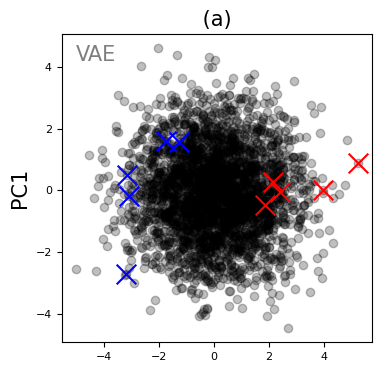

In [48]:
ds_train_enso = dict_enso['train_sample'][var][:-1].rename({'time' : 'lead_time' , 'realization' : 'ensembles'}).stack(time = ('year','lead_time')).transpose('time',...)
ds_mu = dict_mu['clm_VAE3']
label = 'VAE'


plt.figure(figsize=(4,4))
colors = [ 'r','g','b','k','c','olive','m','y','purple','tab:red','orange','tab:blue']

month_idx = 0
for t in range(0,len(ds_train_enso.time)):

    plt.subplot(1,1,1)      
    plt.scatter(ds_mu.sel(ensembles = params['ensemble_list'])[t+month_idx,:,0].values, ds_mu.sel(ensembles = params['ensemble_list'])[t+month_idx,:,1].values, label = f'{ds_mu.time[t+month_idx].values}', color = 'k', alpha = 0.25)# colors[ds_train.lead_time[t].values])
    

plt.subplot(1,1,1) 

elnino_samples=  ds_mu.sel(ensembles = params['ensemble_list']).where(ds_train_enso > np.quantile(ds_train_enso,0.9985)).reset_index('time').stack(d = ('time','ensembles')).transpose(...,'mu').dropna('d')
lanina_samples=  ds_mu.sel(ensembles = params['ensemble_list']).where(ds_train_enso < np.quantile(ds_train_enso,0.0015)).reset_index('time').stack(d = ('time','ensembles')).transpose(...,'mu').dropna('d')
plt.scatter(elnino_samples.values[:,0], elnino_samples.values[:,1], color = 'r', marker = 'x', s = 200)
plt.scatter(lanina_samples.values[:,0], lanina_samples.values[:,1],  color = 'b', marker = 'x', s = 200)

plt.title(' (a) ' , fontsize = 15)
plt.text(-5,4.2, label, fontsize = 15, alpha = 0.5)

# plt.legend(bbox_to_anchor = (1,1))
# plt.xlabel('PCA2', fontsize = 15)
plt.ylabel('PC1', fontsize = 15)

plt.rc('xtick',labelsize=8)
plt.rc('ytick',labelsize=8)

Path(dir_out).mkdir(parents=True, exist_ok=True)
plt.savefig(f'{dir_out}/Figure4_a',
            bbox_inches='tight',
            dpi=300)

plt.show()

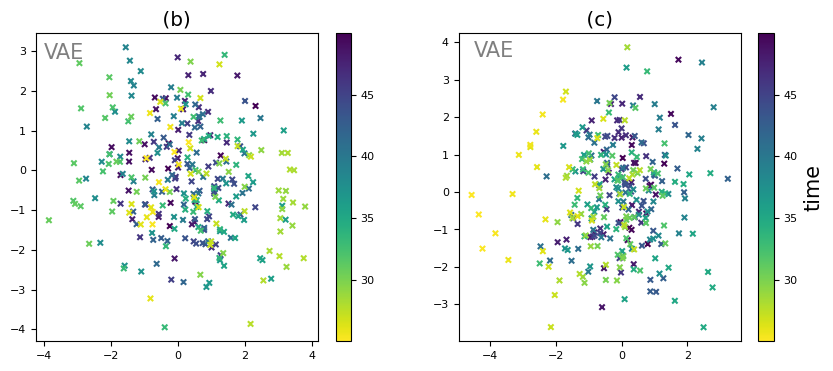

In [44]:
data = dict_mu['clm_VAE3'] # ds_samples

plt.figure(figsize = (10,4))
for ind, e in enumerate([7,8]):
    plt.subplot(1,2,ind+1)
    x = data[-300:,e-1,0].values
    y = data[-300:,e-1,1].values
    z = data.year.values[-300:] + (data.lead_time.values[-300:] - 0.5) /12
    # if ind == 1:
    x = np.flip(x)
    y = np.flip(y)
    z = np.flip(z)
    
    scatter = plt.scatter(x,y ,c=z, cmap='viridis_r', marker = 'x', s = 15)
    cbar = plt.colorbar(scatter)
    if ind == 1:
        
        cbar.set_label('time', fontsize = 15)
    if ind == 0 :
        panel = '(b)'
        plt.text(-4,2.8, 'VAE', fontsize = 15, alpha = 0.5)
    else:
        plt.text(-4.5,3.6, 'VAE', fontsize = 15, alpha = 0.5)
        panel = '(c)'
    plt.title(f' {panel} ')

    
Path(dir_out).mkdir(parents=True, exist_ok=True)
plt.savefig(f'{dir_out}/Figure4_bc',
            bbox_inches='tight',
            dpi=300)

plt.show()

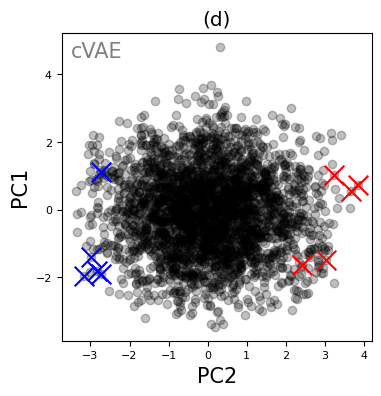

In [47]:
ds_mu = dict_mu['clm_cVAE2']
label = 'cVAE'

plt.figure(figsize=(4,4))
colors = [ 'r','g','b','k','c','olive','m','y','purple','tab:red','orange','tab:blue']

month_idx = 0
for t in range(0,len(ds_train_enso.time)):
    # plt.subplot(1,2,1)
    # plt.scatter(ds_samples.sel(ensembles = params['ensemble_list'])[t+month_idx,:,0].values, ds_samples.sel(ensembles = params['ensemble_list'])[t+month_idx,:,1].values, label = f'{ds_mu.time[t+month_idx].values}', color = 'k' , alpha = 0.25)#colors[ds_train.lead_time[t].values])

    plt.subplot(1,1,1)      
    plt.scatter(ds_mu.sel(ensembles = params['ensemble_list'])[t+month_idx,:,0].values, ds_mu.sel(ensembles = params['ensemble_list'])[t+month_idx,:,1].values, label = f'{ds_mu.time[t+month_idx].values}', color = 'k', alpha = 0.25)# colors[ds_train.lead_time[t].values])
    



plt.subplot(1,1,1) 

elnino_samples=  ds_mu.sel(ensembles = params['ensemble_list']).where(ds_train_enso > np.quantile(ds_train_enso,0.9985)).reset_index('time').stack(d = ('time','ensembles')).transpose(...,'mu').dropna('d')
lanina_samples=  ds_mu.sel(ensembles = params['ensemble_list']).where(ds_train_enso < np.quantile(ds_train_enso,0.0015)).reset_index('time').stack(d = ('time','ensembles')).transpose(...,'mu').dropna('d')
plt.scatter(elnino_samples.values[:,0], elnino_samples.values[:,1], color = 'r', marker = 'x', s = 200)
plt.scatter(lanina_samples.values[:,0], lanina_samples.values[:,1],  color = 'b', marker = 'x', s = 200)

# plt.title('latent space encoding $\mu_{NN}$' + f' - {label}' , fontsize = 15)
plt.text(-3.5,4.5, label, fontsize = 15, alpha = 0.5)
# plt.legend(bbox_to_anchor = (1,1))
plt.xlabel('PC2', fontsize = 15)
plt.ylabel('PC1', fontsize = 15)
plt.title('(d)')
plt.rc('xtick',labelsize=8)
plt.rc('ytick',labelsize=8)

Path(dir_out).mkdir(parents=True, exist_ok=True)
plt.savefig(f'{dir_out}/Figure4_d',
            bbox_inches='tight',
            dpi=300)

plt.show()

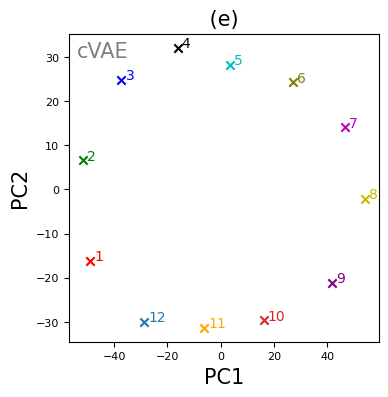

In [46]:
plt.figure(figsize=(4,4))
ds_emb = dict_emb['clm_cVAE2']
label = 'cVAE'
if ds_emb is not None:
    for t in range(0,len(ds_train_enso[:12].time)):
        month = ds_train.lead_time[t].values
        plt.scatter(ds_emb[t,0].values, ds_emb[t,1].values, color = colors[month-1], marker = 'x', label = f'month {month}')
        plt.text(ds_emb[t,0].values + 1.5, ds_emb[t,1].values , month,size = 10, color = colors[month-1])
    # plt.legend(bbox_to_anchor = (1,1)) 
    plt.title(' (e) ', fontsize = 15)
    plt.xlabel('PC1', fontsize = 15)
    plt.ylabel('PC2', fontsize = 15)
    plt.text(-54,30, label, fontsize = 15, alpha = 0.5)
    # plt.legend(bbox_to_anchor = (1,1))
Path(dir_out).mkdir(parents=True, exist_ok=True)
plt.savefig(f'{dir_out}/FigureS4_e',
            bbox_inches='tight',
            dpi=300)
plt.show()

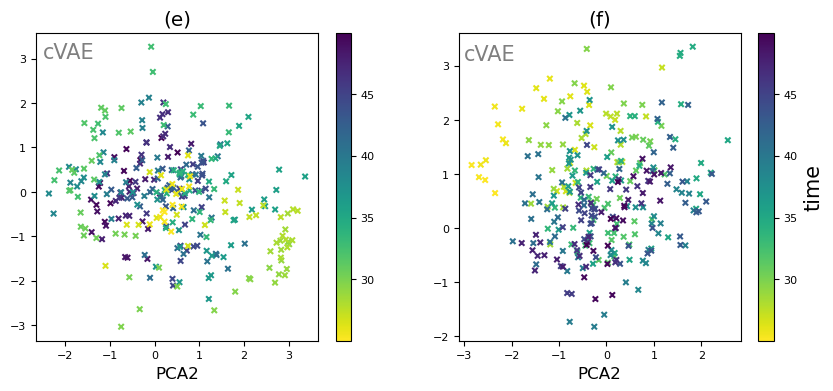

In [271]:
data = dict_mu['clm_cVAE2'] # ds_samples

plt.figure(figsize = (10,4))
for ind, e in enumerate([7,8]):
    plt.subplot(1,2,ind+1)
    x = data[-300:,e-1,0].values
    y = data[-300:,e-1,1].values
    z = data.year.values[-300:] + (data.lead_time.values[-300:] - 0.5) /12
    if ind == 0:
        x = np.flip(x)
        y = np.flip(y)
        z = np.flip(z)
    
    scatter = plt.scatter(x,y ,c=z, cmap='viridis_r', marker = 'x', s = 15)
    cbar = plt.colorbar(scatter)
    if ind == 1:
        cbar.set_label('time', fontsize = 15)
    # plt.title(f'Ensemble member {e}')
    if ind == 0 :
        # plt.ylabel('PCA1')
        label = '(e)'
        plt.text(-2.5,3,'cVAE', fontsize = 15, alpha = 0.5)
    else:
        label = '(f)'
        plt.text(-3,3.1, 'cVAE', fontsize = 15, alpha = 0.5)
    plt.title(label)
    plt.xlabel('PCA2')

Path(dir_out).mkdir(parents=True, exist_ok=True)
plt.savefig(f'{dir_out}/Figure4_ef',
            bbox_inches='tight',
            dpi=300)

plt.show()

- Figure S5

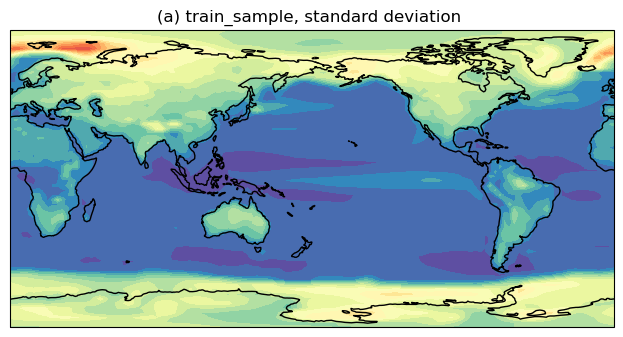

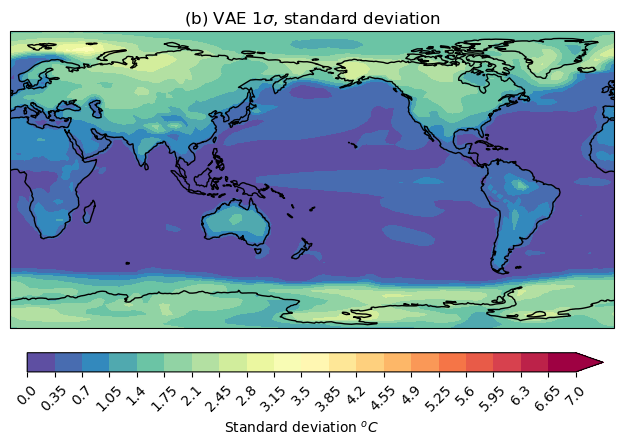

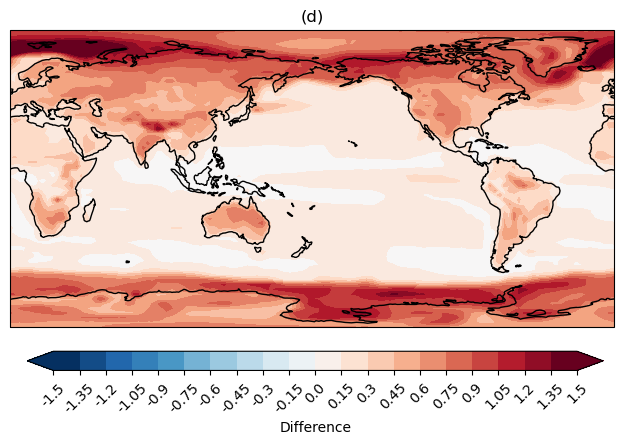

In [295]:
time_to_show = np.arange(1,13) #[1]

ds = dict_anom['train_sample'][var].sel(time=time_to_show).std(['year','realization']).sel(time = time_to_show).mean('time')

plot_map(ds,
                title=f'(a) {dict_clm_plt["train_sample"]["label"]}, standard deviation ',
                    vmin=dict_event_plt[event]['std_vmin'],
                    vmax=dict_event_plt[event]['std_vmax'],
                    cmap='Spectral_r',
                    cbar_extend='max',
                cbar=False,
                nvals = 20,
                fig_dir=f'{dir_out}',
                fig_name=f'FigureS5_a',
                show=True,
                save=True)

ds2 = dict_anom['clm_VAE1'][var].sel(time=time_to_show).std(['realization']).sel(time = time_to_show).mean('time')

plot_map(ds2,
                title=f'(b) {dict_clm_plt["clm_VAE1"]["label"]}, standard deviation',
                    vmin=dict_event_plt[event]['std_vmin'],
                    vmax=dict_event_plt[event]['std_vmax'],
                    cmap='Spectral_r',
                    cbar_extend='max',
                cbar=True,
                nvals = 20,
                ticks_rotation = 45,
                fig_dir=f'{dir_out}',
                fig_name=f'FigureS5_b',
                cbar_label = 'Standard deviation $^{o}C$',
                show=True,
                save=True)


plot_map(ds - ds2,
                title=f'(d)',
                cbar=True,
                nvals = 20,
                fig_dir=f'{dir_out}',
                cbar_label = 'Difference',
                ticks_rotation = 45,
                fig_name=f'FigureS5_c',
                show=True,
                save=True)

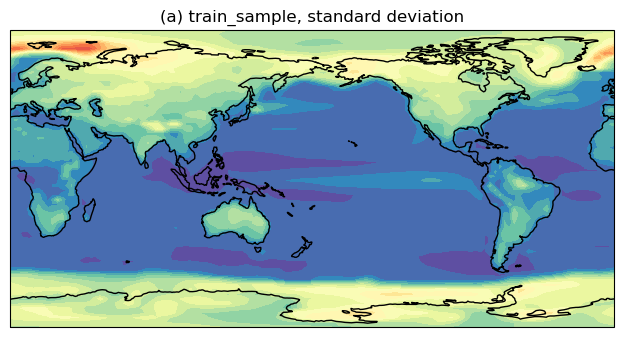

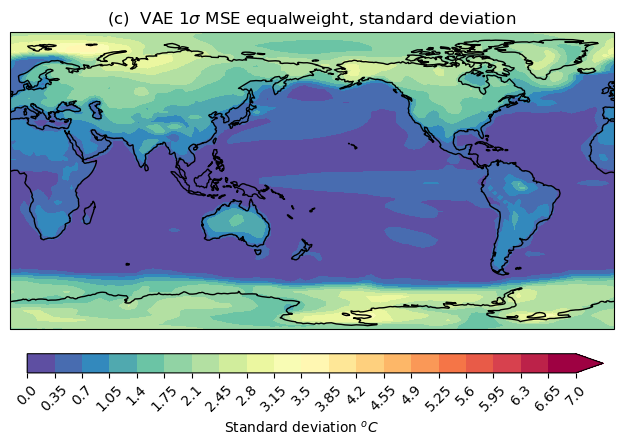

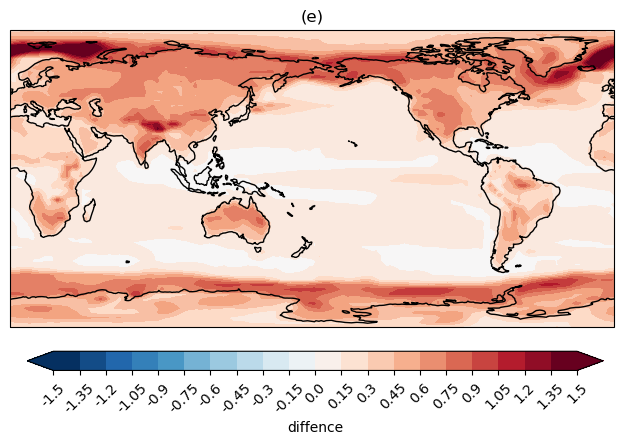

In [292]:
time_to_show = np.arange(1,13) #[1]

ds = dict_anom['train_sample'][var].sel(time=time_to_show).std(['year','realization']).sel(time = time_to_show).mean('time')

plot_map(ds,
                title=f'(a) {dict_clm_plt["train_sample"]["label"]}, standard deviation',
                    vmin=dict_event_plt[event]['std_vmin'],
                    vmax=dict_event_plt[event]['std_vmax'],
                    cmap='Spectral_r',
                    cbar_extend='max',
                cbar=False,
                nvals = 20,
                fig_dir=f'{dir_out}',
                fig_name=f'FigureS5_a',
                show=True,
                save=False)

ds2 = dict_anom['clm_VAE1_'][var].sel(time=time_to_show).std(['realization']).sel(time = time_to_show).mean('time')

plot_map(ds2,
                title=f'(c)  {dict_clm_plt["clm_VAE1_"]["label"]}, standard deviation',
                    vmin=dict_event_plt[event]['std_vmin'],
                    vmax=dict_event_plt[event]['std_vmax'],
                    cmap='Spectral_r',
                    cbar_extend='max',
                cbar=True,
                nvals = 20,
                ticks_rotation = 45,
                fig_dir=f'{dir_out}',
                fig_name=f'FigureS5_d',
                cbar_label = 'Standard deviation $^{o}C$',
                show=True,
                save=True)


plot_map(ds - ds2,
                title=f'(e)',
                cbar=True,
                nvals = 20,
                ticks_rotation = 45,
                fig_dir=f'{dir_out}',
                fig_name=f'FigureS5_e',
                cbar_label = 'diffence',
                show=True,
                save=True)

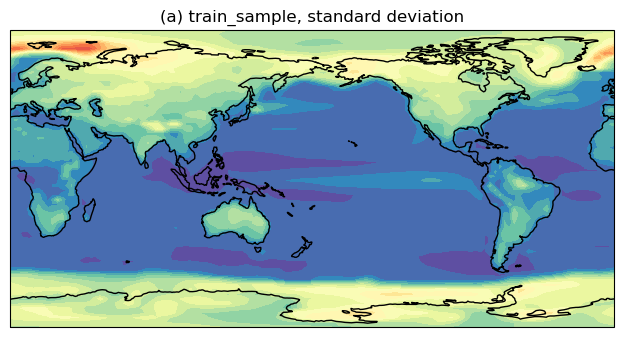

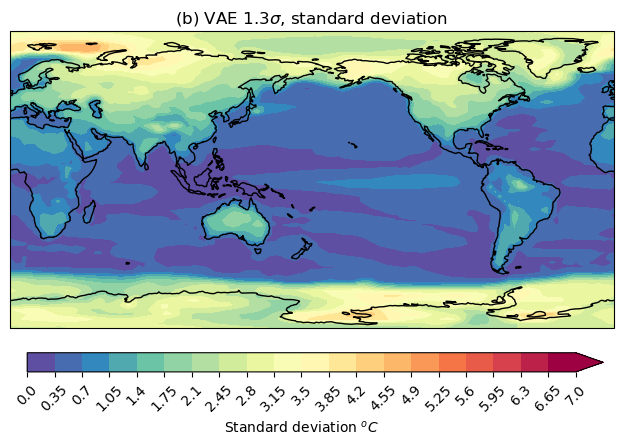

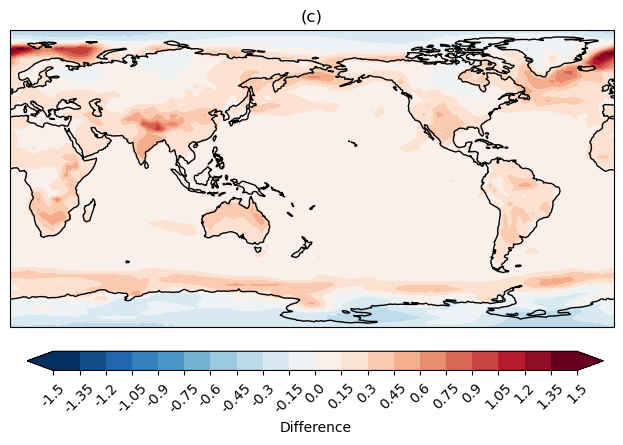

In [293]:
time_to_show = np.arange(1,13) #[1]

ds = dict_anom['train_sample'][var].sel(time=time_to_show).std(['year','realization']).sel(time = time_to_show).mean('time')

plot_map(ds,
                title=f'(a) {dict_clm_plt["train_sample"]["label"]}, standard deviation',
                    vmin=dict_event_plt[event]['std_vmin'],
                    vmax=dict_event_plt[event]['std_vmax'],
                    cmap='Spectral_r',
                    cbar_extend='max',
                cbar=False,
                nvals = 20,
                fig_dir=f'{dir_out}',
                fig_name=f'FigureS6_a',
                show=True,
                save=True)

ds2 = dict_anom['clm_VAE3_'][var].sel(time=time_to_show).std(['realization']).sel(time = time_to_show).mean('time')

plot_map(ds2,
                title=f'(b) {dict_clm_plt["clm_VAE3_"]["label"]}, standard deviation ',
                    vmin=dict_event_plt[event]['std_vmin'],
                    vmax=dict_event_plt[event]['std_vmax'],
                    cmap='Spectral_r',
                    cbar_extend='max',
                cbar=True,
                nvals = 20,
                fig_dir=f'{dir_out}',
                ticks_rotation = 45,
                fig_name=f'FigureS6_b',
                cbar_label = 'Standard deviation $^{o}C$',
                show=True,
                save=True)


plot_map(ds - ds2,
                title=f'(c)',
                cbar=True,
                nvals = 20,
                fig_dir=f'{dir_out}',
                fig_name=f'FigureS6_c',
                ticks_rotation = 45,
                cbar_label = 'Difference',
                show=True,
                save=True)

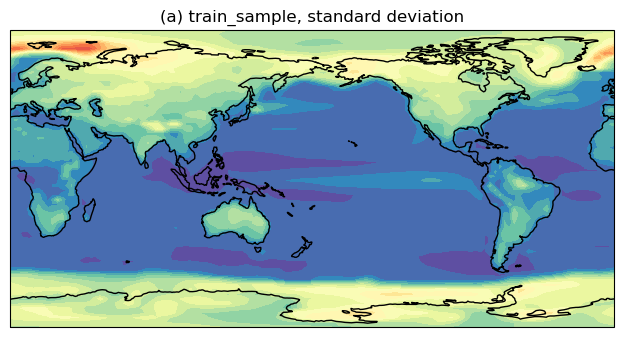

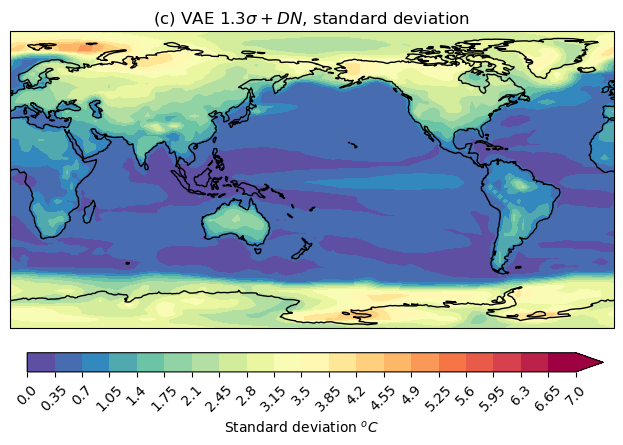

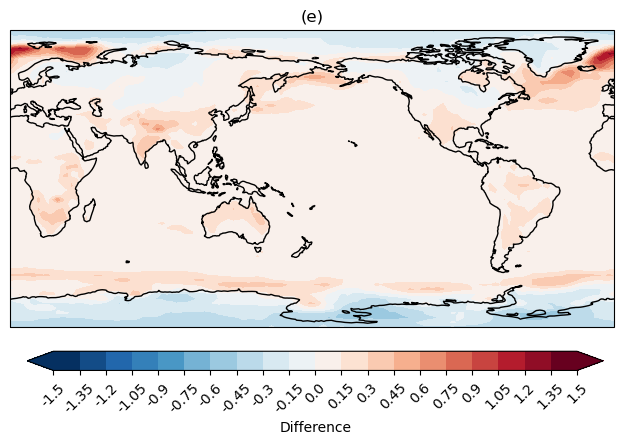

In [294]:
time_to_show = np.arange(1,13) #[1]

ds = dict_anom['train_sample'][var].sel(time=time_to_show).std(['year','realization']).sel(time = time_to_show).mean('time')

plot_map(ds,
                title=f'(a) {dict_clm_plt["train_sample"]["label"]}, standard deviation',
                    vmin=dict_event_plt[event]['std_vmin'],
                    vmax=dict_event_plt[event]['std_vmax'],
                    cmap='Spectral_r',
                    cbar_extend='max',
                cbar=False,
                nvals = 20,
                fig_dir=f'{dir_out}',
                fig_name=f'FigureS6_a',
                show=True,
                save=False)

ds2 = dict_anom['clm_VAE3'][var].sel(time=time_to_show).std(['realization']).sel(time = time_to_show).mean('time')


plot_map(ds2,
                title=f'(c) {dict_clm_plt["clm_VAE3"]["label"]}, standard deviation',
                    vmin=dict_event_plt[event]['std_vmin'],
                    vmax=dict_event_plt[event]['std_vmax'],
                    cmap='Spectral_r',
                    cbar_extend='max',
                cbar=True,
                nvals = 20,
                ticks_rotation = 45,
                fig_dir=f'{dir_out}',
                fig_name=f'FigureS6_d',
                cbar_label = 'Standard deviation $^{o}C$',
                show=True,
                save=True)


plot_map(ds - ds2,
                title=f'(e)',
                cbar=True,
                nvals = 20,
                ticks_rotation = 45,
                fig_dir=f'{dir_out}',
                fig_name=f'FigureS6_e',
                cbar_label = 'Difference',
                show=True,
                save=True)